# TERCER ENFOQUE DE MI PROYECTO
Cambiar a CLASIFICACIÓN, tener como variable target la variedad del vino y predecirla gracias a las variables country, designation y winery

            (Aquí también puedo basarme en mi story telling para justificar esta elección.
            Siempre fiel al hilo de querer crear un recomendador de vinos, esta vez quiero predecir la variedad del vino, 
            igual para recomendar a amigos, y por supuesto no quiero recomendar vinos que sean super raros y difíciles de encontrar. 
            Por lo tanto acotaré primero por el "variety", quedándome SOLO con aquellas variedades de las que hay más de 100.
            Depues, analizaré el nuevo dataframe que se ha quedado y veré si allí quedan "designation" o "winery" también poco frecuentes, 
            y si se diera el caso, cortaría también de allí)

            Finalmente, con estos datos relimpiados y recortados, escogería los 3 mejores modelos de los que ya tenía de antes (de regresión),
            y los pasaría a clasificación

In [103]:

## Primero, cargo todas las librerias 
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px

import re

from scipy.stats import iqr   ### para función que quita los outliers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedKFold, ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix , r2_score, mean_absolute_error, mean_squared_error    

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.naive_bayes import GaussianNB
import multiprocessing
from sklearn.svm import SVC
import xgboost

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer


## PARA LAS TRANSFORMACIONES
from scipy.stats import shapiro
from scipy.stats import skew
from scipy import stats, special

#para guardar el modelo de ML
import pickle

import warnings
warnings.filterwarnings('once')

In [104]:
## cargo el dataframe ya limpio del primer análisis
df = pd.read_csv("../data/processed/vinos_editado.csv")

In [105]:
df.head()

,country,description,designation,points,price,province,region_1,taster_name,variety,winery,year
0,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,Riesling,St. Julian,2013
1,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Pinot Noir,Sweet Cheeks,2012
2,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tempranillo-Merlot,Tandem,2011
3,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Frappato,Terre di Giurfo,2013
4,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Pinot Gris,Jean-Baptiste Adam,2012


### REDUCIR DATOS
Para que el recomendador de vinos se adapte mejor a mi entorno más cercano, que es dónde se usará, y así poder recomendar con bastante confianza unos vinos que sean relativamente fáciles de encontrar

#### LIMPIEZA INICIAL "VARIETY"  --> me quedo con las que producen más de 100 botellas

In [106]:
### Haré una "limpieza inicial", quedándome solo con los vinos de los que haya más de 100 botellas por variedad
## (si quiero recomendar vinos, quiero que sean vinos relativamente fáciles de encontrar)
## luego ya iré viendo si necesito acotar más

In [107]:
frecuencias_variedades = pd.DataFrame(df['variety'].value_counts().sort_values(ascending=False))
frecuencias_variedades

,variety
Pinot Noir,6076
Chardonnay,4329
Red Blend,4248
Cabernet Sauvignon,2872
Bordeaux-style Red Blend,2044
...,...
Picapoll,1
Syrah-Bonarda,1
Tinta Madeira,1
Centesimino,1


In [108]:
mask = frecuencias_variedades["variety"] > 100  ## defino la máscara

print("Total variedades de las que hay más de 100 unidades:",len(frecuencias_variedades[mask]))  ## como ya sabía de mi análisis anterior, son 47 las variedades de vino que tienen más de 100 unidades
                                   ## me voy a quedar solo con éstas para seguir con mis modelos
vars_100 = frecuencias_variedades[mask]
# print("Primeras 3 variedades de la lista:\n", vars_100.head(3))
# print("Últimas 3 variedades de la lista:\n", vars_100.tail(3))  ## me quedo hasta la variedad "G-S-M" incluida
## quiero pasar el índice (los nombres de las variedades) a la columna normal, para luego unirlo al dataframe grade y quedarme solo con estas variedades

# vars_100["variety_100"] = vars_100.index
# vars_100.head()   ### añado la columna "variety_100" con el nombre de las 47 variedades con las que me quedo
#                     ### no pierdo tiempo en resetear el index, ya que ahora fusionaré esta columa con el dataframe principal

Total variedades de las que hay más de 100 unidades: 47


In [109]:
# creo un diccionario con las etiquetas de los vinos y sus respectivos números
# ordenados según la cantidad de cada vino
char2idx = {u:i for i, u in enumerate(vars_100.index)}
print(char2idx)   ### para ver el diccionario que me ha creado

#### AHORA TENGO QUE PASARLOS A DATAFRAME, AL NUEVO DATAFRAME DE TODOS VALORES NUMERICOS
#### QUE USARÉ PARA LOS MODELOS DE MACHINE LEARNING

df_variety_num = pd.DataFrame([[key, char2idx[key]] for key in char2idx.keys()], columns=['variety', 'variety_100'])


{'Pinot Noir': 0, 'Chardonnay': 1, 'Red Blend': 2, 'Cabernet Sauvignon': 3, 'Bordeaux-style Red Blend': 4, 'Syrah': 5, 'Riesling': 6, 'Malbec': 7, 'Rosé': 8, 'Tempranillo': 9, 'Nebbiolo': 10, 'Sauvignon Blanc': 11, 'Zinfandel': 12, 'White Blend': 13, 'Rhône-style Red Blend': 14, 'Sangiovese': 15, 'Merlot': 16, 'Pinot Gris': 17, 'Cabernet Franc': 18, 'Gamay': 19, 'Sparkling Blend': 20, 'Tempranillo Blend': 21, 'Gewürztraminer': 22, 'Shiraz': 23, 'Viognier': 24, 'Grenache': 25, 'Champagne Blend': 26, 'Rhône-style White Blend': 27, 'Petite Sirah': 28, 'Chenin Blanc': 29, 'Barbera': 30, 'Garnacha': 31, 'Melon': 32, 'Bordeaux-style White Blend': 33, 'Albariño': 34, 'Pinot Grigio': 35, 'Torrontés': 36, 'Pinot Blanc': 37, 'Glera': 38, 'Tinta de Toro': 39, "Nero d'Avola": 40, 'Verdejo': 41, 'Petit Verdot': 42, 'Mourvèdre': 43, 'Aglianico': 44, 'Mencía': 45, 'G-S-M': 46}


In [110]:
df_variety_num["variety_100"] = (df_variety_num["variety_100"] + 1)
vars_100 = df_variety_num.sort_values(by= "variety_100")
 #incremento de uno para que si luego tuviera que escalar esta columna no me de error (me pasó en el anterior análisis así que por si acaso lo hago ya)


In [111]:
vars_100.head()

,variety,variety_100
0,Pinot Noir,1
1,Chardonnay,2
2,Red Blend,3
3,Cabernet Sauvignon,4
4,Bordeaux-style Red Blend,5


In [112]:
df = df.merge(vars_100, how="outer")  ## ahora los tengo unidos, después haré un dropna de va columna variety_100

In [113]:
df.info()  ## variety_100  42770 non-null -->> mi dataframe tendrá que tener este largo

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47142 entries, 0 to 47141
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      47142 non-null  object 
 1   description  47142 non-null  object 
 2   designation  47142 non-null  object 
 3   points       47142 non-null  int64  
 4   price        47142 non-null  float64
 5   province     47142 non-null  object 
 6   region_1     47142 non-null  object 
 7   taster_name  47142 non-null  object 
 8   variety      47142 non-null  object 
 9   winery       47142 non-null  object 
 10  year         47142 non-null  int64  
 11  variety_100  42770 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 4.7+ MB


In [114]:
df = df.dropna(subset=["variety_100"])

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42770 entries, 0 to 45436
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      42770 non-null  object 
 1   description  42770 non-null  object 
 2   designation  42770 non-null  object 
 3   points       42770 non-null  int64  
 4   price        42770 non-null  float64
 5   province     42770 non-null  object 
 6   region_1     42770 non-null  object 
 7   taster_name  42770 non-null  object 
 8   variety      42770 non-null  object 
 9   winery       42770 non-null  object 
 10  year         42770 non-null  int64  
 11  variety_100  42770 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 4.2+ MB


In [80]:
# df.drop(["variety"], axis = 1, inplace=True)  ## ahora la columna "variety" la tengo doble, la borro y me quedo con la que se llama "variety_100"
### la borro luego, al final de esta seccion (para tener ambas versiones de csv y que sean de fácil acceso)

In [116]:
df.describe(include="all")   ## comprobación de los valores únicos. Ya sé que de "variety_num" tengo 47
                                ## de designation tengo más de 20000 y de winery tengo casi 8000, tengo que hacer la misma limpieza con estas 2 columnas para quitarme del medio los valores raros

,country,description,designation,points,price,province,region_1,taster_name,variety,winery,year,variety_100
count,42770,42770,42770,42770.00000,42770.000000,42770,42770,42770,42770,42770,42770.000000,42770.000000
unique,7,42764,20498,NaN,NaN,58,903,17,47,7827,NaN,NaN
top,US,In 2009 this single vineyard offering includes...,Reserve,NaN,NaN,California,Columbia Valley (WA),Roger Voss,Pinot Noir,Columbia Crest,NaN,NaN
freq,22094,2,1030,NaN,NaN,11887,2141,6971,6076,137,NaN,NaN
mean,NaN,NaN,NaN,89.09509,40.540659,NaN,NaN,NaN,NaN,NaN,2011.445055,10.106664
std,NaN,NaN,NaN,3.02400,36.387473,NaN,NaN,NaN,NaN,NaN,3.290666,10.058636
min,NaN,NaN,NaN,80.00000,4.000000,NaN,NaN,NaN,NaN,NaN,1904.000000,1.000000
25%,NaN,NaN,NaN,87.00000,20.000000,NaN,NaN,NaN,NaN,NaN,2010.000000,3.000000
50%,NaN,NaN,NaN,89.00000,30.000000,NaN,NaN,NaN,NaN,NaN,2012.000000,7.000000
75%,NaN,NaN,NaN,91.00000,50.000000,NaN,NaN,NaN,NaN,NaN,2014.000000,14.000000


#### LIMPIEZA INICIAL "DESIGNATION"  --> de las que producen más de 100 botellas, me quedo con las que tienen más de 20 viñedos

In [117]:
df

,country,description,designation,points,price,province,region_1,taster_name,variety,winery,year,variety_100
0,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,Riesling,St. Julian,2013,7.0
1,US,A wisp of bramble extends a savory tone from n...,Ingle Vineyard,88,20.0,New York,Finger Lakes,Anna Lee C. Iijima,Riesling,Heron Hill,2015,7.0
2,US,"Dusty mineral, smoke and struck flint lend a s...",Red Oak Vineyard,87,20.0,New York,Finger Lakes,Anna Lee C. Iijima,Riesling,Lamoreaux Landing,2014,7.0
3,US,Intensely smoky tones of struck flint and ash ...,Yellow Dog Vineyard,87,20.0,New York,Finger Lakes,Anna Lee C. Iijima,Riesling,Lamoreaux Landing,2014,7.0
4,US,More complex than the winery's appellation ble...,Claiborne Vineyard,91,28.0,California,Edna Valley,Matt Kettmann,Riesling,Claiborne & Churchill,2014,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...
45432,US,"The aromas are brooding, with notes of red fru...",L'Idiot du Village,93,42.0,Washington,Columbia Valley (WA),Sean P. Sullivan,Mourvèdre,Gramercy,2014,44.0
45433,Australia,"The vineyard was planted in 1853, so these are...",Old Garden Vineyard,93,82.0,South Australia,Barossa Valley,Joe Czerwinski,Mourvèdre,Hewitson,2013,44.0
45434,US,A blend of Ciel du Cheval and Force Majeure vi...,Crazy Mary,93,48.0,Washington,Red Mountain,Sean P. Sullivan,Mourvèdre,Mark Ryan,2012,44.0
45435,Australia,"For a wine that's 100% Mourvèdre, this has pre...",The Twentyeight Road,89,35.0,South Australia,McLaren Vale,Joe Czerwinski,Mourvèdre,D'Arenberg,2006,44.0


In [118]:
## Partiendo del último dataframe con las variedades más comunes, voy a ver la frecuencia de los viñedos (= designation)

frec_designation = pd.DataFrame(df['designation'].value_counts().sort_values(ascending=False))
frec_designation.head()


,designation
Reserve,1030
Estate,797
Reserva,435
Estate Grown,365
Riserva,348


In [119]:
### me quedaré con aquellas variedades de las que hay más de 20 viñedos
mask = frec_designation["designation"] >= 20  ## defino la máscara

print("Total variedades de las que hay más de 20 viñedos:",len(frec_designation[mask])) 

Total variedades de las que hay más de 20 viñedos: 99


In [120]:
desig_20 = frec_designation[mask]
print("Primeros 3 viñedos de la lista:\n", desig_20.head(3))
print("Últimos 3 viñedos de la lista:\n", desig_20.tail(3))  ## me quedo hasta el viñedo "Buissonnier" incluido
## quiero pasar el índice (los nombres de las "designation") a la columna normal, para luego unirlo al dataframe grande y quedarme solo con estos

desig_20["designation_20"] = desig_20.index
desig_20.head()   

Primeros 3 viñedos de la lista:
          designation
Reserve         1030
Estate           797
Reserva          435
Últimos 3 viñedos de la lista:
                        designation
Coro Mendocino                  21
La Encantada Vineyard           21
Buissonnier                     20


C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,designation,designation_20
Reserve,1030,Reserve
Estate,797,Estate
Reserva,435,Reserva
Estate Grown,365,Estate Grown
Riserva,348,Riserva


In [121]:
desig_20["designation"] = desig_20.index  ## tengo que volver a hacer esto y pasar los nombres a la columna "designation" (ya no me interesa quedarme con las frecuencias
                                        ## y esto es necesario porque luego lo quiero mergear con el dataframe principal y ahora no me dejaba)
desig_20.head()

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,designation,designation_20
Reserve,Reserve,Reserve
Estate,Estate,Estate
Reserva,Reserva,Reserva
Estate Grown,Estate Grown,Estate Grown
Riserva,Riserva,Riserva


In [122]:
df = df.merge(desig_20, how="outer")  ## ahora los tengo unidos, después haré un dropna de la columna designation_20

In [123]:
df.info()  ## designation_20  7465 non-null    -->> mi dataframe tendrá que tener este largo

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42770 entries, 0 to 42769
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         42770 non-null  object 
 1   description     42770 non-null  object 
 2   designation     42770 non-null  object 
 3   points          42770 non-null  int64  
 4   price           42770 non-null  float64
 5   province        42770 non-null  object 
 6   region_1        42770 non-null  object 
 7   taster_name     42770 non-null  object 
 8   variety         42770 non-null  object 
 9   winery          42770 non-null  object 
 10  year            42770 non-null  int64  
 11  variety_100     42770 non-null  float64
 12  designation_20  7465 non-null   object 
dtypes: float64(2), int64(2), object(9)
memory usage: 4.6+ MB


In [124]:
df = df.dropna(subset=["designation_20"])

In [125]:
df.drop(["designation"], axis = 1, inplace=True)  ## ahora la columna "designation" la tengo doble, la borro y me quedo con la que se llama "designation_20"

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7465 entries, 55 to 41204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         7465 non-null   object 
 1   description     7465 non-null   object 
 2   points          7465 non-null   int64  
 3   price           7465 non-null   float64
 4   province        7465 non-null   object 
 5   region_1        7465 non-null   object 
 6   taster_name     7465 non-null   object 
 7   variety         7465 non-null   object 
 8   winery          7465 non-null   object 
 9   year            7465 non-null   int64  
 10  variety_100     7465 non-null   float64
 11  designation_20  7465 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 758.2+ KB


In [127]:
df.describe(include="all")   ## comprobación de los valores únicos. Ya veo que de "variety_100" tengo 47, de "designation_20" tengo 99
                             ## ahora toca ver si puedo acotar aún más con las bodegas (winery)

,country,description,points,price,province,region_1,taster_name,variety,winery,year,variety_100,designation_20
count,7465,7465,7465.000000,7465.000000,7465,7465,7465,7465,7465,7465.000000,7465.000000,7465
unique,7,7464,NaN,NaN,50,409,16,47,2517,NaN,NaN,99
top,US,"Cigar box, café au lait, and dried tobacco aro...",NaN,NaN,California,Columbia Valley (WA),Michael Schachner,Chardonnay,Columbia Crest,NaN,NaN,Reserve
freq,4408,2,NaN,NaN,2159,481,1411,984,76,NaN,NaN,1030
mean,NaN,NaN,88.486135,33.613262,NaN,NaN,NaN,NaN,NaN,2011.218218,9.944943,NaN
std,NaN,NaN,2.945531,29.591160,NaN,NaN,NaN,NaN,NaN,3.437458,9.567975,NaN
min,NaN,NaN,80.000000,4.000000,NaN,NaN,NaN,NaN,NaN,1929.000000,1.000000,NaN
25%,NaN,NaN,86.000000,18.000000,NaN,NaN,NaN,NaN,NaN,2010.000000,2.000000,NaN
50%,NaN,NaN,88.000000,26.000000,NaN,NaN,NaN,NaN,NaN,2012.000000,7.000000,NaN
75%,NaN,NaN,91.000000,40.000000,NaN,NaN,NaN,NaN,NaN,2014.000000,15.000000,NaN


#### LIMPIEZA INICIAL "WINERY"  --> de las que producen más de 100 botellas y tienen más de 20 viñedos, me quedo con las que tienen por lo menos 3 bodegas

In [128]:
df

,country,description,points,price,province,region_1,taster_name,variety,winery,year,variety_100,designation_20
55,France,"Subtle notes of clean, fresh lemon zest promis...",92,39.0,Alsace,Alsace,Anne Krebiehl MW,Riesling,Kuentz-Bas,2014,7.0,Pfersigberg Grand Cru
56,France,The tart but tropical charm of passion fruit p...,94,49.0,Alsace,Alsace,Anne Krebiehl MW,Riesling,Domaine Zinck,2015,7.0,Pfersigberg Grand Cru
57,France,Incredibly pure notes of freshly cut Cox's Ora...,94,40.0,Alsace,Alsace,Anne Krebiehl MW,Riesling,Martin Schaetzel,2012,7.0,Pfersigberg Grand Cru
58,France,"Floral aromas lead into a rich, not quite dry ...",92,48.0,Alsace,Alsace,Roger Voss,Riesling,Domaine Zinck,2011,7.0,Pfersigberg Grand Cru
59,France,Softly scented with tart apple and fresh citru...,94,40.0,Alsace,Alsace,Anne Krebiehl MW,Riesling,Martin Schaetzel,2013,7.0,Pfersigberg Grand Cru
...,...,...,...,...,...,...,...,...,...,...,...,...
41200,France,"This is just right, balanced with plenty of cr...",87,13.0,Loire Valley,Muscadet Sèvre et Maine,Roger Voss,Melon,Domaine du Fief aux Dames,2013,33.0,Sur Lie
41201,France,Crisp lemon aromas follow through to an equall...,86,14.0,Loire Valley,Muscadet Sèvre et Maine,Roger Voss,Melon,Domaine du Colombier,2016,33.0,Sur Lie
41202,France,This soft and fruity wine has open white fruit...,87,12.0,Loire Valley,Muscadet Sèvre et Maine,Roger Voss,Melon,Chateau de l'Oiselinière,2015,33.0,Sur Lie
41203,France,This crisp Muscadet offers an attractive bite ...,86,18.0,Loire Valley,Muscadet Sèvre et Maine,Roger Voss,Melon,Domaine Michel Brégeon,2012,33.0,Sur Lie


In [129]:
## Partiendo del último dataframe con las variedades más comunes, voy a ver la frecuencia de las bodegas (= winery)

frec_winery = pd.DataFrame(df['winery'].value_counts().sort_values(ascending=False))
frec_winery

,winery
Columbia Crest,76
Trapiche,55
Chateau Ste. Michelle,54
Novelty Hill,49
Maryhill,34
...,...
Peter Franus,1
Maison Hebrard,1
Château Lapinesse,1
Château Camarsac,1


In [130]:
### me quedaré con aquellas variedades de las que hay más de 3 bodegas  (que por lo menos haya 3 bodagas que producen cada tipo de vino)
mask = frec_winery["winery"] >= 3  ## defino la máscara

print("Total variedades de las que hay más de 3 bodegas:",len(frec_winery[mask])) 

Total variedades de las que hay más de 3 bodegas: 839


In [131]:
winery_3 = frec_winery[mask]
print("Primeras 3 bodegas de la lista:\n", winery_3.head(3))
print("Primeras 3 bodegas de la lista:\n", winery_3.tail(3))  ## me quedo hasta el viñedo "Les Frères Perroud" incluida
## quiero pasar el índice (los nombres de las "winery") a la columna normal, para luego unirlo al dataframe grande y quedarme solo con estos

winery_3["winery_3"] = winery_3.index
winery_3.head()   

Primeras 3 bodegas de la lista:
                        winery
Columbia Crest             76
Trapiche                   55
Chateau Ste. Michelle      54
Primeras 3 bodegas de la lista:
                     winery
Hightower                3
Elizabeth Chambers       3
Les Frères Perroud       3


C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,winery,winery_3
Columbia Crest,76,Columbia Crest
Trapiche,55,Trapiche
Chateau Ste. Michelle,54,Chateau Ste. Michelle
Novelty Hill,49,Novelty Hill
Maryhill,34,Maryhill


In [132]:
winery_3["winery"] = winery_3.index  ## tengo que volver a hacer esto y pasar los nombres a la columna "winery" (ya no me interesa quedarme con las frecuencias
                                        ## y esto es necesario porque luego lo quiero mergear con el dataframe principal y ahora no me dejaba )
winery_3.head()

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,winery,winery_3
Columbia Crest,Columbia Crest,Columbia Crest
Trapiche,Trapiche,Trapiche
Chateau Ste. Michelle,Chateau Ste. Michelle,Chateau Ste. Michelle
Novelty Hill,Novelty Hill,Novelty Hill
Maryhill,Maryhill,Maryhill


In [133]:
df = df.merge(winery_3, how="outer")  ## ahora los tengo unidos, después haré un dropna de la columna winery_10

In [134]:
df.info()  ## winery_3        5297 non-null   -->> mi dataframe tendrá que tener este largo

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7465 entries, 0 to 7464
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         7465 non-null   object 
 1   description     7465 non-null   object 
 2   points          7465 non-null   int64  
 3   price           7465 non-null   float64
 4   province        7465 non-null   object 
 5   region_1        7465 non-null   object 
 6   taster_name     7465 non-null   object 
 7   variety         7465 non-null   object 
 8   winery          7465 non-null   object 
 9   year            7465 non-null   int64  
 10  variety_100     7465 non-null   float64
 11  designation_20  7465 non-null   object 
 12  winery_3        5297 non-null   object 
dtypes: float64(2), int64(2), object(9)
memory usage: 816.5+ KB


In [135]:
df = df.dropna(subset=["winery_3"])

In [136]:
df.drop(["winery"], axis = 1, inplace=True)  ## ahora la columna "winery" la tengo doble, la borro y me quedo con la que se llama "winery_3"

In [137]:
df

,country,description,points,price,province,region_1,taster_name,variety,year,variety_100,designation_20,winery_3
0,France,"Subtle notes of clean, fresh lemon zest promis...",92,39.0,Alsace,Alsace,Anne Krebiehl MW,Riesling,2014,7.0,Pfersigberg Grand Cru,Kuentz-Bas
1,France,"This is a rich wine, labeled sweet but with a ...",93,59.0,Alsace,Alsace,Roger Voss,Gewürztraminer,2012,23.0,Pfersigberg Grand Cru,Kuentz-Bas
2,France,Softly hinted aromatics of dried peach suggest...,90,45.0,Alsace,Alsace,Anne Krebiehl MW,Gewürztraminer,2014,23.0,Pfersigberg Grand Cru,Kuentz-Bas
3,France,"Still very closed up, this is a potentially ri...",91,59.0,Alsace,Alsace,Roger Voss,Gewürztraminer,2013,23.0,Pfersigberg Grand Cru,Kuentz-Bas
4,France,"A delicate, crisp, very pure wine. It has perf...",88,17.0,Alsace,Alsace,Roger Voss,Riesling,2011,7.0,Tradition,Kuentz-Bas
...,...,...,...,...,...,...,...,...,...,...,...,...
7439,Italy,"Truffle, underbrush, dark berry, mocha and gri...",91,70.0,Piedmont,Barolo,Kerin O’Keefe,Nebbiolo,2011,11.0,Monvigliero,Bel Colle
7440,Italy,"Fragrant and loaded with finesse, this opens w...",94,70.0,Piedmont,Barolo,Kerin O’Keefe,Nebbiolo,2012,11.0,Monvigliero,Bel Colle
7442,Italy,"Subdued aromas of menthol, dark spice and a wh...",92,76.0,Piedmont,Barolo,Kerin O’Keefe,Nebbiolo,2012,11.0,Monvigliero,Fratelli Alessandria
7443,Italy,"Scents of woodland berry, rose petal, grilled ...",91,75.0,Piedmont,Barolo,Kerin O’Keefe,Nebbiolo,2011,11.0,Monvigliero,Fratelli Alessandria


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5297 entries, 0 to 7444
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         5297 non-null   object 
 1   description     5297 non-null   object 
 2   points          5297 non-null   int64  
 3   price           5297 non-null   float64
 4   province        5297 non-null   object 
 5   region_1        5297 non-null   object 
 6   taster_name     5297 non-null   object 
 7   variety         5297 non-null   object 
 8   year            5297 non-null   int64  
 9   variety_100     5297 non-null   float64
 10  designation_20  5297 non-null   object 
 11  winery_3        5297 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 538.0+ KB


In [139]:
df.describe(include="all")   ## comprobación de los valores únicos. Ya veo que de "variety_100" tengo 47, de "winery_10" he bajado a  839
                             ## y de designation me he quedado con 99 valos únicos

,country,description,points,price,province,region_1,taster_name,variety,year,variety_100,designation_20,winery_3
count,5297,5297,5297.000000,5297.000000,5297,5297,5297,5297,5297.000000,5297.000000,5297,5297
unique,7,5296,NaN,NaN,33,258,16,47,NaN,NaN,99,839
top,US,"Cigar box, café au lait, and dried tobacco aro...",NaN,NaN,California,Columbia Valley (WA),Michael Schachner,Chardonnay,NaN,NaN,Reserve,Columbia Crest
freq,3397,2,NaN,NaN,1496,441,1020,762,NaN,NaN,767,76
mean,NaN,NaN,88.552011,32.156315,NaN,NaN,NaN,NaN,2011.348310,9.805928,NaN,NaN
std,NaN,NaN,2.889712,26.211018,NaN,NaN,NaN,NaN,3.202104,9.512737,NaN,NaN
min,NaN,NaN,80.000000,4.000000,NaN,NaN,NaN,NaN,1994.000000,1.000000,NaN,NaN
25%,NaN,NaN,87.000000,17.000000,NaN,NaN,NaN,NaN,2010.000000,2.000000,NaN,NaN
50%,NaN,NaN,88.000000,26.000000,NaN,NaN,NaN,NaN,2012.000000,7.000000,NaN,NaN
75%,NaN,NaN,91.000000,40.000000,NaN,NaN,NaN,NaN,2014.000000,15.000000,NaN,NaN


In [140]:
## guardo una version de csv CON LA COLUMNA "variety" original, me servirá luego si uso el NLP y tokenizer
df.to_csv("..\\data\\processed\\vinos_para_NLP_model.csv", index=False) 

In [141]:
df.drop(["variety"], axis = 1, inplace=True)  

In [142]:
df  ## ahora veo que ya no está la columna "variety", solo está su versión numérica
### guardo este dataframe aquí abajo

,country,description,points,price,province,region_1,taster_name,year,variety_100,designation_20,winery_3
0,France,"Subtle notes of clean, fresh lemon zest promis...",92,39.0,Alsace,Alsace,Anne Krebiehl MW,2014,7.0,Pfersigberg Grand Cru,Kuentz-Bas
1,France,"This is a rich wine, labeled sweet but with a ...",93,59.0,Alsace,Alsace,Roger Voss,2012,23.0,Pfersigberg Grand Cru,Kuentz-Bas
2,France,Softly hinted aromatics of dried peach suggest...,90,45.0,Alsace,Alsace,Anne Krebiehl MW,2014,23.0,Pfersigberg Grand Cru,Kuentz-Bas
3,France,"Still very closed up, this is a potentially ri...",91,59.0,Alsace,Alsace,Roger Voss,2013,23.0,Pfersigberg Grand Cru,Kuentz-Bas
4,France,"A delicate, crisp, very pure wine. It has perf...",88,17.0,Alsace,Alsace,Roger Voss,2011,7.0,Tradition,Kuentz-Bas
...,...,...,...,...,...,...,...,...,...,...,...
7439,Italy,"Truffle, underbrush, dark berry, mocha and gri...",91,70.0,Piedmont,Barolo,Kerin O’Keefe,2011,11.0,Monvigliero,Bel Colle
7440,Italy,"Fragrant and loaded with finesse, this opens w...",94,70.0,Piedmont,Barolo,Kerin O’Keefe,2012,11.0,Monvigliero,Bel Colle
7442,Italy,"Subdued aromas of menthol, dark spice and a wh...",92,76.0,Piedmont,Barolo,Kerin O’Keefe,2012,11.0,Monvigliero,Fratelli Alessandria
7443,Italy,"Scents of woodland berry, rose petal, grilled ...",91,75.0,Piedmont,Barolo,Kerin O’Keefe,2011,11.0,Monvigliero,Fratelli Alessandria


In [143]:
## creo que ya he acotado suficientes datos como para poder empezar con los modelos de machine learning
## antes guardaré este dataframe como csv para tenerlo más cómodo


df.to_csv("..\\data\\processed\\vinos_var100_des20_win3.csv", index=False) 

### PASAR LAS COLUMNAS DE CATEGÓRICAS A NUMÉRICAS --> get dummies

In [39]:
## Antes de transformar a numéricas las columnas, me quedo solo con aquellas que usaré para mi modelo, así qeu voy a cargarme el csv y prescindir de las columnas
## description y taster_name
## al principio pensaba quitar también province y region_1, pero de momento las dejo, las uso para empezar los modelos de clasificación y las iré quitando poco a poco según los resultados que me salgan

df_3 = pd.read_csv("..\\data\\processed\\vinos_var100_des20_win3.csv")

In [40]:
df_3.head()

,description,points,price,province,region_1,taster_name,year,variety_100,designation_20,winery_3
country,,,,,,,,,,
France,"Subtle notes of clean, fresh lemon zest promis...",92,39.0,Alsace,Alsace,Anne Krebiehl MW,2014,7.0,Pfersigberg Grand Cru,Kuentz-Bas
France,"This is a rich wine, labeled sweet but with a ...",93,59.0,Alsace,Alsace,Roger Voss,2012,23.0,Pfersigberg Grand Cru,Kuentz-Bas
France,Softly hinted aromatics of dried peach suggest...,90,45.0,Alsace,Alsace,Anne Krebiehl MW,2014,23.0,Pfersigberg Grand Cru,Kuentz-Bas
France,"Still very closed up, this is a potentially ri...",91,59.0,Alsace,Alsace,Roger Voss,2013,23.0,Pfersigberg Grand Cru,Kuentz-Bas
France,"A delicate, crisp, very pure wine. It has perf...",88,17.0,Alsace,Alsace,Roger Voss,2011,7.0,Tradition,Kuentz-Bas


In [41]:
df_3.drop(["description", "taster_name"], axis = 1, inplace= True)

In [42]:
df_3

,points,price,province,region_1,year,variety_100,designation_20,winery_3
country,,,,,,,,
France,92,39.0,Alsace,Alsace,2014,7.0,Pfersigberg Grand Cru,Kuentz-Bas
France,93,59.0,Alsace,Alsace,2012,23.0,Pfersigberg Grand Cru,Kuentz-Bas
France,90,45.0,Alsace,Alsace,2014,23.0,Pfersigberg Grand Cru,Kuentz-Bas
France,91,59.0,Alsace,Alsace,2013,23.0,Pfersigberg Grand Cru,Kuentz-Bas
France,88,17.0,Alsace,Alsace,2011,7.0,Tradition,Kuentz-Bas
...,...,...,...,...,...,...,...,...
Italy,91,70.0,Piedmont,Barolo,2011,11.0,Monvigliero,Bel Colle
Italy,94,70.0,Piedmont,Barolo,2012,11.0,Monvigliero,Bel Colle
Italy,92,76.0,Piedmont,Barolo,2012,11.0,Monvigliero,Fratelli Alessandria


In [43]:
### ahora procedo a hacer un get_dummies
df_3_dumm = pd.get_dummies(data = df_3)

In [44]:
df_3_dumm   ## ahora tengo 5297 rows × 1233 columns

,points,price,year,variety_100,province_Alsace,province_Australia Other,province_Beaujolais,province_Bordeaux,province_British Columbia,province_Burgundy,...,winery_3_Yering Station,winery_3_Ysios,winery_3_ZD,winery_3_Zaca Mesa,winery_3_Zenith,winery_3_Zinfandelic,winery_3_Zolo,winery_3_Zotovich Cellars,winery_3_Zuani,winery_3_àMaurice
country,,,,,,,,,,,,,,,,,,,,,
France,92,39.0,2014,7.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
France,93,59.0,2012,23.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
France,90,45.0,2014,23.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
France,91,59.0,2013,23.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
France,88,17.0,2011,7.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Italy,91,70.0,2011,11.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Italy,94,70.0,2012,11.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Italy,92,76.0,2012,11.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### OUTLIERS

In [45]:
## los outliers de "years" no me preocupan, pero sí quiero quitar los de "price"

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


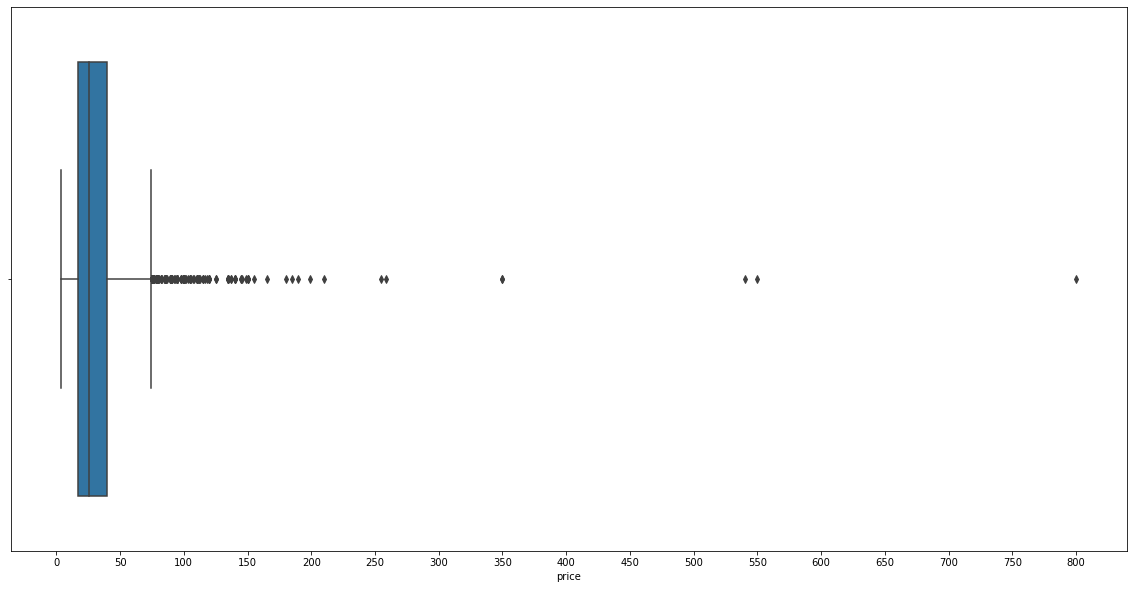

In [46]:
plt.figure(figsize=(20,10))
sns.boxplot(df_3_dumm["price"]);
plt.xticks(np.arange(0,850, 50));

In [47]:
## quito outliers de la columna price
def outliers_quantie(df, feature, param=1.5):  
        
    iqr_ = iqr(df[feature], nan_policy='omit')
    q1 = np.nanpercentile(df[feature], 25)
    q3 = np.nanpercentile(df[feature], 75)
    
    th1 = q1 - iqr_*param
    th2 = q3 + iqr_*param
    
    return df[(df[feature] >= th1) & (df[feature] <= th2)].reset_index(drop=True)

df_3_dumm_no_out = outliers_quantie(df_3_dumm, 'price')  ## dejo el parámetro por defect de 1.5, así veo que me ha quitado muchos más outliers que en las pruebas anteriores
print("Len original:", len(df_3_dumm))
print("Len sin outliers en price:", len(df_3_dumm_no_out))

Len original: 5297
Len sin outliers en price: 5076


C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


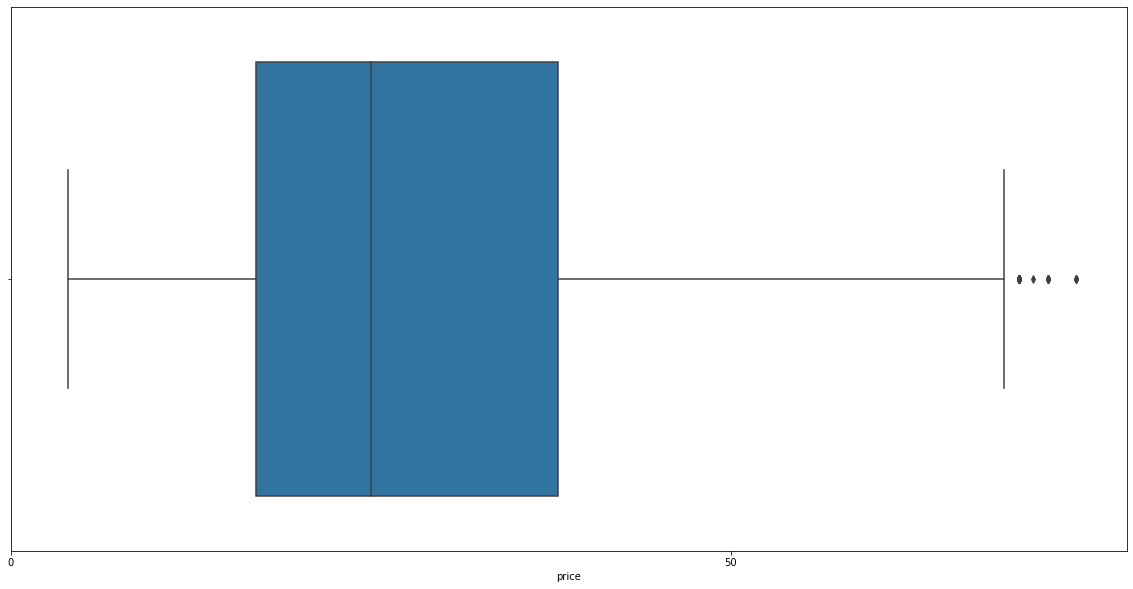

In [48]:
plt.figure(figsize=(20,10))
sns.boxplot(df_3_dumm_no_out["price"]);
plt.xticks(np.arange(0,100, 50));

In [49]:
## voy a usar este dataframe (y también lo guardo)
df_3_dumm_no_out.to_csv("..\\data\\processed\\vinos_var100_des20_win3_noOutliers.csv", index=False) 

### PRUEBAS VARIAS PARA MODELOS DE MACHINE LEARNING
Ahora mi problema es de CLASIFICACIÓN MULTICLASE, ya que quiero predecir la variedad del vino

In [50]:
## ahora lo cargo con un nombre más corto y lo uso para los modelos de ML
df_3 = pd.read_csv("..\\data\\processed\\vinos_var100_des20_win3_noOutliers.csv")

In [51]:
df_3

,points,price,year,variety_100,province_Alsace,province_Australia Other,province_Beaujolais,province_Bordeaux,province_British Columbia,province_Burgundy,...,winery_3_Yering Station,winery_3_Ysios,winery_3_ZD,winery_3_Zaca Mesa,winery_3_Zenith,winery_3_Zinfandelic,winery_3_Zolo,winery_3_Zotovich Cellars,winery_3_Zuani,winery_3_àMaurice
0,92,39.0,2014,7.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,93,59.0,2012,23.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,90,45.0,2014,23.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,91,59.0,2013,23.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,88,17.0,2011,7.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5071,90,49.0,2013,11.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5072,91,70.0,2012,11.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5073,95,65.0,2010,11.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5074,91,70.0,2011,11.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 1º MODELO - REGRESIÓN LOGISTICA
- Acierto: 56.69 %
- Error: 43.31 %

In [52]:
## definición "X" e "y"
X1 = df_3.drop(["variety_100"], axis = 1)
y1 = np.array(df_3["variety_100"]).reshape(-1,)

## separo en train y test
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, random_state=12)

## compruebo las divisiones:
print("Total features shape:", X1.shape)
print("Train features shape:", X1_train.shape)
print("Train target shape:", X1_test.shape)
print("Test features shape:", y1_train.shape)
print("Test target shape:", y1_test.shape)

Total features shape: (5076, 1232)
Train features shape: (4060, 1232)
Train target shape: (1016, 1232)
Test features shape: (4060,)
Test target shape: (1016,)


In [53]:
## defino el modelo
log_reg1 = LogisticRegression(max_iter = 1000)

# Creo el scaler con los datos de train
scal = StandardScaler() # Declaro el scaler
scal.fit(X1_train) # Lo "entreno"
X1_train = scal.transform(X1_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X1_test = scal.transform(X1_test)

## entreno el modelo
log_reg1.fit(X1_train, y1_train)

## hago la predicción
predictions1 = log_reg1.predict(X1_test)
predictions1

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


array([ 1.,  1.,  2., ...,  7., 29., 11.])

In [54]:
### metricas

acierto = accuracy_score(y1_test, predictions1)
error = 1 - acierto

print("Acierto:", round(acierto*100, 2), "%")
print("Error:", round(error*100, 2), "%")
print("------")
print("Score del modelo (accuracy):", round(accuracy_score(y1_test, predictions1),3))
print("Recall score:\n", recall_score(y1_test, predictions1,average=None, zero_division= 0))
print("Precision score:\n", precision_score(y1_test, predictions1, average=None, zero_division= 0))
print("F1 score:\n", f1_score(y1_test, predictions1, average=None))

predicions_proba = log_reg1.predict_proba(X1_test)
print("Prediccion proba: \n",np.round(np.array(predicions_proba), 2))




Acierto: 56.69 %
Error: 43.31 %
------
Score del modelo (accuracy): 0.567
Recall score:
 [0.7751938  0.58571429 0.70588235 0.36956522 0.85       0.39285714
 0.65625    0.55       0.4        0.78787879 1.         0.45454545
 0.6875     0.25       1.         0.53846154 0.33333333 0.26666667
 0.2        0.9        0.42857143 0.64       0.42857143 1.
 0.375      0.375      0.66666667 1.         0.75       0.33333333
 0.25       0.         1.         1.         1.         0.
 0.57142857 0.33333333 0.         1.         0.         0.
 0.25       1.         0.        ]
Precision score:
 [0.70422535 0.64566929 0.70588235 0.45945946 0.80952381 0.23913043
 0.72413793 0.55932203 0.57142857 0.8        1.         0.6
 0.42307692 0.33333333 0.6        0.5        0.39393939 0.28571429
 0.18181818 1.         0.5        0.66666667 0.35294118 0.5
 0.46153846 0.27272727 0.5        0.5        0.15       1.
 0.33333333 0.         1.         0.5        0.5        0.
 1.         0.21428571 0.         1.     

#### 2º MODELO - RANDOM FOREST CLASSIFIER
- Acierto: 52.17 %
- Error: 47.83 %

In [55]:
## definición "X" e "y"
X2 = df_3.drop(["variety_100"], axis = 1)
y2 = np.array(df_3["variety_100"]).reshape(-1,)

## separo en train y test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state=12)

## compruebo las divisiones:
print("Total features shape:", X2.shape)
print("Train features shape:", X2_train.shape)
print("Train target shape:", X2_test.shape)
print("Test features shape:", y2_train.shape)
print("Test target shape:", y2_test.shape)

Total features shape: (5076, 1232)
Train features shape: (4060, 1232)
Train target shape: (1016, 1232)
Test features shape: (4060,)
Test target shape: (1016,)


In [56]:
## con el random forest no hace falta que escale pero anteriormente hice una prueba sin escalar y salió muy mal, así que hago un StandardScaler

scal = StandardScaler() # Declaro el scaler
scal.fit(X2_train) # Lo "entreno". Calculo su media y std para cada feature
X2_train = scal.transform(X2_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X2_test = scal.transform(X2_test)

# Creación del modelo
rnd_for2 = RandomForestClassifier(random_state= 42) 

rnd_for2.fit(X2_train,y2_train)

## hacer la prediccion
predictions2 = rnd_for2.predict(X2_test)
predictions2

array([ 2.,  7.,  2., ...,  7.,  2., 11.])

In [57]:
### metricas

acierto2 = accuracy_score(y2_test, predictions2)
error2 = 1 - acierto2

print("Acierto:", round(acierto2*100, 2), "%")
print("Error:", round(error2*100, 2), "%")
print("------")
print("Score del modelo (accuracy):", round(accuracy_score(y2_test, predictions2),3))
print("Recall score:\n", recall_score(y2_test, predictions2,average=None, zero_division= 0))
print("Precision score:\n", precision_score(y2_test, predictions2, average=None, zero_division= 0))
print("F1 score:\n", f1_score(y2_test, predictions2, average=None))

predicions_proba2 = rnd_for2.predict_proba(X2_test)
print("Prediccion proba: \n",np.round(np.array(predicions_proba2), 2))


Acierto: 52.17 %
Error: 47.83 %
------
Score del modelo (accuracy): 0.522
Recall score:
 [0.72093023 0.5        0.67647059 0.34782609 0.7        0.46428571
 0.70833333 0.51666667 0.26666667 0.72727273 1.         0.24242424
 0.625      0.25       1.         0.38461538 0.17948718 0.4
 0.2        0.9        0.28571429 0.6        0.46428571 1.
 0.1875     0.375      1.         0.         0.5        0.33333333
 0.25       0.         1.         1.         1.         0.
 0.57142857 0.11111111 1.         1.         0.         0.11111111
 0.         1.         0.        ]
Precision score:
 [0.62       0.49295775 0.76666667 0.34408602 0.60869565 0.30952381
 0.70103093 0.55357143 0.66666667 0.68571429 1.         0.53333333
 0.47619048 0.5        0.5        0.38461538 0.23333333 0.4137931
 0.16666667 1.         0.66666667 0.625      0.40625    0.33333333
 0.33333333 0.3        1.         0.         0.22222222 1.
 0.2        0.         1.         0.5        0.5        0.
 1.         0.07692308 1.  

#### 3º MODELO - SVC  --> el mejor resultado es con el kernel = sigmoid >>> 52.26%
- Acierto_lin: 48.92 %
- Error_lin: 51.08 %
-
- Acierto_pol: 48.62 %
- Error_pol: 51.38 %
-
- Acierto_rbf: 51.48 %
- Error_rbf: 48.52 %
-
- Acierto_sig: 52.26 %
- Error_sig: 47.74 %


In [59]:
## definición "X" e "y"
X3 = df_3.drop(["variety_100"], axis = 1)
y3 = np.array(df_3["variety_100"]).reshape(-1, 1)

## separo en train y test
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.2, random_state=12)

## compruebo las divisiones:
print("Total features shape:", X3.shape)
print("Train features shape:", X3_train.shape)
print("Train target shape:", X3_test.shape)
print("Test features shape:", y3_train.shape)
print("Test target shape:", y3_test.shape)

Total features shape: (5076, 1232)
Train features shape: (4060, 1232)
Train target shape: (1016, 1232)
Test features shape: (4060, 1)
Test target shape: (1016, 1)


In [60]:
## escalo los datos
scal = StandardScaler() # Declaro el scaler
scal.fit(X3_train) # Lo "entreno"
X3_train = scal.transform(X3_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X3_test = scal.transform(X3_test)


#Defino el algoritmo a utilizar
svc3_lin = SVC(kernel='linear', C=100, probability= True)  
svc3_pol = SVC(kernel='poly', C=100, gamma="scale", probability= True)      
svc3_rbf = SVC(kernel='rbf', C=100, probability= True)   
svc3_sig = SVC(kernel='sigmoid', C=100, probability= True)  


#Entreno el modelo
svc3_lin.fit(X3_train, y3_train)
svc3_pol.fit(X3_train, y3_train)
svc3_rbf.fit(X3_train, y3_train)
svc3_sig.fit(X3_train, y3_train)

#Realizo una predicción
predictions3_lin = svc3_lin.predict(X3_test)
predictions3_lin

predictions3_pol = svc3_pol.predict(X3_test)
predictions3_pol

predictions3_rbf = svc3_rbf.predict(X3_test)
predictions3_rbf

predictions3_sig = svc3_sig.predict(X3_test)
predictions3_sig

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:985: DataConve

array([ 1.,  7.,  1., ...,  7., 29., 11.])

In [61]:
### metricas

acierto3_lin = accuracy_score(y3_test, predictions3_lin)
error3_lin = 1 - acierto3_lin

print("Acierto_lin:", round(acierto3_lin*100, 2), "%")
print("Error_lin:", round(error3_lin*100, 2), "%")
print("------")

acierto3_pol = accuracy_score(y3_test, predictions3_pol)
error3_pol = 1 - acierto3_pol

print("Acierto_pol:", round(acierto3_pol*100, 2), "%")
print("Error_pol:", round(error3_pol*100, 2), "%")
print("------")

acierto3_rbf = accuracy_score(y3_test, predictions3_rbf)
error3_rbf = 1 - acierto3_rbf

print("Acierto_rbf:", round(acierto3_rbf*100, 2), "%")
print("Error_rbf:", round(error3_rbf*100, 2), "%")
print("------")

acierto3_sig = accuracy_score(y3_test, predictions3_sig)
error3_sig = 1 - acierto3_sig

print("Acierto_sig:", round(acierto3_sig*100, 2), "%")
print("Error_sig:", round(error3_sig*100, 2), "%")
print("------")
# print("Score del modelo (accuracy):", round(accuracy_score(y3_test, predictions3),3))
# print("Recall score:\n", recall_score(y3_test, predictions3,average=None, zero_division= 0))
# print("Precision score:\n", precision_score(y3_test, predictions3, average=None, zero_division= 0))
# print("F1 score:\n", f1_score(y3_test, predictions3, average=None))

# predicions_proba3 = svc3_lin.predict_proba(X3_test)
# print("Prediccion proba: \n",np.round(np.array(predicions_proba3), 2))

Acierto_lin: 48.92 %
Error_lin: 51.08 %
------
Acierto_pol: 48.62 %
Error_pol: 51.38 %
------
Acierto_rbf: 51.48 %
Error_rbf: 48.52 %
------
Acierto_sig: 52.26 %
Error_sig: 47.74 %
------


#### 4º MODELO - HIST GRADIENT BOOSTING CLASSIFIER  --> el PEOR hasta ahora

- Acierto: 12.11 %
- Error: 87.89 %

In [62]:
## definición "X" e "y"
X4 = df_3.drop(["variety_100"], axis = 1)
y4 = np.array(df_3["variety_100"]).reshape(-1,)

## separo en train y test
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size = 0.2, random_state=12)

## compruebo las divisiones:
print("Total features shape:", X4.shape)
print("Train features shape:", X4_train.shape)
print("Train target shape:", X4_test.shape)
print("Test features shape:", y4_train.shape)
print("Test target shape:", y4_test.shape)

Total features shape: (5076, 1232)
Train features shape: (4060, 1232)
Train target shape: (1016, 1232)
Test features shape: (4060,)
Test target shape: (1016,)


In [63]:
## escalo los datos
scal = StandardScaler() # Declaro el scaler
scal.fit(X4_train) # Lo "entreno"
X4_train = scal.transform(X4_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X4_test = scal.transform(X4_test)

# entreno el modelo
hgb4 = HistGradientBoostingClassifier()
hgb4.fit(X4_train, y4_train)

## hago las predicciones
predictions4 = hgb4.predict(X = X4_test)
predictions4

array([1., 1., 1., ..., 1., 1., 1.])

In [64]:
### metricas

acierto4 = accuracy_score(y4_test, predictions4)
error4 = 1 - acierto4

print("Acierto:", round(acierto4*100, 2), "%")
print("Error:", round(error4*100, 2), "%")
print("------")
print("Score del modelo (accuracy):", round(accuracy_score(y4_test, predictions4),3))
print("Recall score:\n", recall_score(y4_test, predictions4,average=None, zero_division= 0))
print("Precision score:\n", precision_score(y4_test, predictions4, average=None, zero_division= 0))
print("F1 score:\n", f1_score(y4_test, predictions4, average=None))

predicions_proba4 = hgb4.predict_proba(X4_test)
print("Prediccion proba: \n",np.round(np.array(predicions_proba4), 2))

Acierto: 12.11 %
Error: 87.89 %
------
Score del modelo (accuracy): 0.121
Recall score:
 [0.94573643 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.0625     0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Precision score:
 [0.12828601 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.01754386 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
F1 score:
 [0.22592

#### 5º MODELO - GRADIENT BOOSTING CLASSIFIER

- Acierto: 54.23 %
- Error: 45.77 %

In [65]:
## definición "X" e "y"
X5 = df_3.drop(["variety_100"], axis = 1)
y5 = np.array(df_3["variety_100"]).reshape(-1,)

## separo en train y test
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size = 0.2, random_state=12)

## compruebo las divisiones:
print("Total features shape:", X5.shape)
print("Train features shape:", X5_train.shape)
print("Train target shape:", X5_test.shape)
print("Test features shape:", y5_train.shape)
print("Test target shape:", y5_test.shape)

Total features shape: (5076, 1232)
Train features shape: (4060, 1232)
Train target shape: (1016, 1232)
Test features shape: (4060,)
Test target shape: (1016,)


In [66]:
## escalo los datos, 
scal = StandardScaler() # Declaro el scaler
scal.fit(X5_train) # Lo "entreno"
X5_train = scal.transform(X5_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X5_test = scal.transform(X5_test)

#defino el modelo
grboost5 = GradientBoostingClassifier(random_state=42)
# lo entreno
grboost5.fit(X5_train, y5_train)

# hago las predicciones
predictions5 = grboost5.predict(X5_test)
predictions5

array([ 2.,  7.,  1., ...,  7.,  2., 11.])

In [67]:
### metricas

acierto5 = accuracy_score(y5_test, predictions5)
error5 = 1 - acierto5

print("Acierto:", round(acierto5*100, 2), "%")
print("Error:", round(error5*100, 2), "%")
print("------")
print("Score del modelo (accuracy):", round(accuracy_score(y5_test, predictions5),3))
print("Recall score:\n", recall_score(y5_test, predictions5,average=None, zero_division= 0))
print("Precision score:\n", precision_score(y5_test, predictions5, average=None, zero_division= 0))
print("F1 score:\n", f1_score(y5_test, predictions5, average=None))

predicions_proba5 = grboost5.predict_proba(X5_test)
print("Prediccion proba: \n",np.round(np.array(predicions_proba5), 2))

Acierto: 54.23 %
Error: 45.77 %
------
Score del modelo (accuracy): 0.542
Recall score:
 [0.71317829 0.61428571 0.70588235 0.26086957 0.7        0.39285714
 0.72916667 0.63333333 0.33333333 0.75757576 1.         0.24242424
 0.75       0.5        1.         0.69230769 0.05128205 0.26666667
 0.25       0.9        0.42857143 0.68       0.46428571 1.
 0.125      0.375      0.66666667 1.         0.75       0.33333333
 0.25       0.         1.         1.         1.         0.
 0.42857143 0.33333333 1.         0.66666667 0.         0.11111111
 0.         1.         0.        ]
Precision score:
 [0.71875    0.48044693 0.70588235 0.35294118 0.7        0.36666667
 0.72164948 0.58461538 0.52631579 0.83333333 1.         0.5
 0.46153846 0.5        0.42857143 0.45       0.08       0.42105263
 0.19230769 1.         0.42857143 0.65384615 0.34210526 1.
 0.28571429 0.3        1.         0.33333333 0.3        1.
 0.2        0.         1.         1.         0.5        0.
 1.         0.25       1.         

#### 6º MODELO - XGBOOST CLASSIFIER

- Acierto: 51.87 %
- Error: 48.13 %

In [68]:
## definición "X" e "y"
X6 = df_3.drop(["variety_100"], axis = 1)
y6 = np.array(df_3["variety_100"]).reshape(-1,)

## separo en train y test
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, test_size = 0.2, random_state=12)

## compruebo las divisiones:
print("Total features shape:", X6.shape)
print("Train features shape:", X6_train.shape)
print("Train target shape:", X6_test.shape)
print("Test features shape:", y6_train.shape)
print("Test target shape:", y6_test.shape)

Total features shape: (5076, 1232)
Train features shape: (4060, 1232)
Train target shape: (1016, 1232)
Test features shape: (4060,)
Test target shape: (1016,)


In [69]:
## escalo los datos
scal = StandardScaler() # Declaro el scaler
scal.fit(X6_train) # Lo "entreno". Calculo su media y std para cada feature
X6_train = scal.transform(X6_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X6_test = scal.transform(X6_test)
xgb6 = xgboost.XGBClassifier(random_state=42)

xgb6.fit(X6_train, y6_train)

predictions6 = xgb6.predict(X6_test)
predictions6

C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:51:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([ 1., 18.,  2., ...,  7., 31., 11.])

In [70]:
### metricas

acierto6 = accuracy_score(y6_test, predictions6)
error6 = 1 - acierto6

print("Acierto:", round(acierto6*100, 2), "%")
print("Error:", round(error6*100, 2), "%")
print("------")
print("Score del modelo (accuracy):", round(accuracy_score(y6_test, predictions6),3))
print("Recall score:\n", recall_score(y6_test, predictions6,average=None, zero_division= 0))
print("Precision score:\n", precision_score(y6_test, predictions6, average=None, zero_division= 0))
print("F1 score:\n", f1_score(y6_test, predictions6, average=None))

predicions_proba6 = xgb6.predict_proba(X6_test)
print("Prediccion proba: \n",np.round(np.array(predicions_proba6), 2))

Acierto: 51.87 %
Error: 48.13 %
------
Score del modelo (accuracy): 0.519
Recall score:
 [0.72093023 0.55714286 0.58823529 0.36956522 0.6        0.35714286
 0.72916667 0.6        0.33333333 0.74242424 1.         0.27272727
 0.5        0.25       0.66666667 0.46153846 0.28205128 0.2
 0.15       0.9        0.28571429 0.48       0.42857143 0.
 0.375      0.125      1.         0.         0.5        0.33333333
 0.         0.         0.         1.         0.         0.
 0.28571429 0.22222222 0.         1.         0.         0.
 0.         1.         0.        ]
Precision score:
 [0.65034965 0.52348993 0.8        0.34693878 0.57142857 0.3030303
 0.7        0.57142857 0.76923077 0.65333333 1.         0.40909091
 0.47058824 0.33333333 0.5        0.4        0.2972973  0.26086957
 0.15789474 1.         0.33333333 0.57142857 0.4        0.
 0.35294118 0.125      0.75       0.         0.15384615 1.
 0.         0.         0.         0.5        0.         0.
 0.66666667 0.16666667 0.         1.       

#### 7º MODELO - ADABOOST CLASSIFIER    --> el segundo PEOR, después del HistGradientBoost

- Acierto: 19.59 %
- Error: 80.41 %

In [71]:
## definición "X" e "y"
X7 = df_3.drop(["variety_100"], axis = 1)
y7 = np.array(df_3["variety_100"]).reshape(-1,)

## separo en train y test
X7_train, X7_test, y7_train, y7_test = train_test_split(X7, y7, test_size = 0.2, random_state=12)

## compruebo las divisiones:
print("Total features shape:", X7.shape)
print("Train features shape:", X7_train.shape)
print("Train target shape:", X7_test.shape)
print("Test features shape:", y7_train.shape)
print("Test target shape:", y7_test.shape)

Total features shape: (5076, 1232)
Train features shape: (4060, 1232)
Train target shape: (1016, 1232)
Test features shape: (4060,)
Test target shape: (1016,)


In [72]:
## escalo los datos, 
scal = StandardScaler() # Declaro el scaler
scal.fit(X7_train) # Lo entreno
X7_train = scal.transform(X7_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X7_test = scal.transform(X7_test)

#defino el modelo
adaboost7 = AdaBoostClassifier(random_state=42)
# lo entreno
adaboost7.fit(X7_train, y7_train)

# hago las predicciones
predictions7 = adaboost7.predict(X7_test)
predictions7


array([2., 2., 2., ..., 2., 2., 2.])

In [73]:
### metricas

acierto7 = accuracy_score(y7_test, predictions7)
error7 = 1 - acierto7

print("Acierto:", round(acierto7*100, 2), "%")
print("Error:", round(error7*100, 2), "%")
print("------")
print("Score del modelo (accuracy):", round(accuracy_score(y7_test, predictions7),3))
print("Recall score:\n", recall_score(y7_test, predictions7,average=None, zero_division= 0))
print("Precision score:\n", precision_score(y7_test, predictions7, average=None, zero_division= 0))
print("F1 score:\n", f1_score(y7_test, predictions7, average=None))

predicions_proba7 = adaboost7.predict_proba(X7_test)
print("Prediccion proba: \n",np.round(np.array(predicions_proba7), 2))

Acierto: 19.59 %
Error: 80.41 %
------
Score del modelo (accuracy): 0.196
Recall score:
 [0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.74242424 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.9        0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.5        0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Precision score:
 [0.         0.15283843 0.         0.         0.         0.
 0.         0.         0.         0.54444444 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
F1 score:
 [0.     

#### 8º MODELO - KNN

- Acierto: 47.15 %
- Error: 52.85 %

In [74]:
## definición "X" e "y"
X8 = df_3.drop(["variety_100"], axis = 1)
y8 = np.array(df_3["variety_100"]).reshape(-1,)

## separo en train y test
X8_train, X8_test, y8_train, y8_test = train_test_split(X8, y8, test_size = 0.2, random_state=12)

## compruebo las divisiones:
print("Total features shape:", X8.shape)
print("Train features shape:", X8_train.shape)
print("Train target shape:", X8_test.shape)
print("Test features shape:", y8_train.shape)
print("Test target shape:", y8_test.shape)

Total features shape: (5076, 1232)
Train features shape: (4060, 1232)
Train target shape: (1016, 1232)
Test features shape: (4060,)
Test target shape: (1016,)


In [76]:
## escalo los datos, 
scal = StandardScaler() # Declaro el scaler
scal.fit(X8_train) # Lo entreno
X8_train = scal.transform(X8_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X8_test = scal.transform(X8_test)

#defino el modelo
knn8 = KNeighborsClassifier(2) 
# lo entreno
knn8.fit(X8_train, y8_train)

# hago las predicciones
predictions8 = knn8.predict(X8_test)
predictions8

array([ 1.,  1.,  1., ...,  7.,  2., 11.])

In [77]:
### metricas

acierto8 = accuracy_score(y8_test, predictions8)
error8 = 1 - acierto8

print("Acierto:", round(acierto8*100, 2), "%")
print("Error:", round(error8*100, 2), "%")
print("------")
print("Score del modelo (accuracy):", round(accuracy_score(y8_test, predictions8),3))
print("Recall score:\n", recall_score(y8_test, predictions8,average=None, zero_division= 0))
print("Precision score:\n", precision_score(y8_test, predictions8, average=None, zero_division= 0))
print("F1 score:\n", f1_score(y8_test, predictions8, average=None))

predicions_proba8 = knn8.predict_proba(X8_test)
print("Prediccion proba: \n",np.round(np.array(predicions_proba8), 2))

Acierto: 47.15 %
Error: 52.85 %
------
Score del modelo (accuracy): 0.471
Recall score:
 [0.7751938  0.43571429 0.76470588 0.30434783 0.85       0.35714286
 0.65625    0.38333333 0.43333333 0.71212121 0.90909091 0.21212121
 0.4375     0.25       1.         0.38461538 0.1025641  0.26666667
 0.1        0.8        0.14285714 0.44       0.25       0.
 0.0625     0.125      0.33333333 0.         0.25       0.33333333
 0.25       0.         1.         0.         0.         0.28571429
 0.11111111 1.         1.         0.         0.         0.
 1.         0.        ]
Precision score:
 [0.54347826 0.37654321 0.61904762 0.23931624 0.68       0.25
 0.66315789 0.43396226 0.68421053 0.734375   1.         0.29166667
 0.31818182 0.25       0.75       0.38461538 0.19047619 0.32
 0.14285714 1.         0.2        0.61111111 0.38888889 0.
 0.16666667 0.2        1.         0.         0.5        1.
 1.         0.         1.         0.         0.         1.
 0.5        1.         1.         0.         0.   

#### 9º MODELO - NAIVE BAYES

- Acierto: 43.7 %
- Error: 56.3 %

In [78]:
## definición "X" e "y"
X9 = df_3.drop(["variety_100"], axis = 1)
y9 = np.array(df_3["variety_100"]).reshape(-1,)

## separo en train y test
X9_train, X9_test, y9_train, y9_test = train_test_split(X9, y9, test_size = 0.2, random_state=12)

## compruebo las divisiones:
print("Total features shape:", X9.shape)
print("Train features shape:", X9_train.shape)
print("Train target shape:", X9_test.shape)
print("Test features shape:", y9_train.shape)
print("Test target shape:", y9_test.shape)

Total features shape: (5076, 1232)
Train features shape: (4060, 1232)
Train target shape: (1016, 1232)
Test features shape: (4060,)
Test target shape: (1016,)


In [79]:
## escalo los datos, 
scal = StandardScaler() # Declaro el scaler
scal.fit(X9_train) # Lo entreno
X9_train = scal.transform(X9_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X9_test = scal.transform(X9_test)


# creo el modelo
nbc9 =GaussianNB()

# lo entreno
nbc9.fit(X9_train, y9_train)

# hago las predicciones
predictions9 = nbc9.predict(X9_test)
predictions9


array([ 1.,  7.,  1., ...,  7., 43., 11.])

In [80]:
### metricas

acierto9 = accuracy_score(y9_test, predictions9)
error9 = 1 - acierto9

print("Acierto:", round(acierto9*100, 2), "%")
print("Error:", round(error9*100, 2), "%")
print("------")
print("Score del modelo (accuracy):", round(accuracy_score(y9_test, predictions9),3))
print("Recall score:\n", recall_score(y9_test, predictions9,average=None, zero_division= 0))
print("Precision score:\n", precision_score(y9_test, predictions9, average=None, zero_division= 0))
print("F1 score:\n", f1_score(y9_test, predictions9, average=None))

predicions_proba9 = knn8.predict_proba(X9_test)
print("Prediccion proba: \n",np.round(np.array(predicions_proba9), 2))

Acierto: 43.7 %
Error: 56.3 %
------
Score del modelo (accuracy): 0.437
Recall score:
 [0.63565891 0.23571429 0.61764706 0.07608696 0.9        0.32142857
 0.33333333 0.55       0.4        0.54545455 1.         0.36363636
 0.6875     0.25       1.         0.61538462 0.15384615 0.26666667
 0.3        0.9        0.71428571 0.84       0.53571429 1.
 0.25       0.5        1.         1.         0.5        0.33333333
 0.75       0.         1.         1.         1.         0.
 0.71428571 0.44444444 1.         1.         0.         0.55555556
 0.5        1.         0.        ]
Precision score:
 [0.66129032 0.73333333 0.67741935 0.30434783 0.72       0.47368421
 0.76190476 0.53225806 0.375      0.85714286 1.         0.4137931
 0.31428571 0.5        0.5        0.28571429 0.20689655 0.24242424
 0.14285714 1.         0.625      0.46666667 0.2        0.16666667
 0.23529412 0.18181818 0.5        0.25       0.14285714 0.25
 0.125      0.         1.         0.5        0.5        0.
 0.20833333 0.108108

#### 10º MODELO - DECISION TREE

- Acierto: 47.05 %
- Error: 52.95 %

In [81]:
## definición "X" e "y"
X10 = df_3.drop(["variety_100"], axis = 1)
y10 = np.array(df_3["variety_100"]).reshape(-1,)

## separo en train y test
X10_train, X10_test, y10_train, y10_test = train_test_split(X10, y10, test_size = 0.2, random_state=12)

## compruebo las divisiones:
print("Total features shape:", X10.shape)
print("Train features shape:", X10_train.shape)
print("Train target shape:", X10_test.shape)
print("Test features shape:", y10_train.shape)
print("Test target shape:", y10_test.shape)

Total features shape: (5076, 1232)
Train features shape: (4060, 1232)
Train target shape: (1016, 1232)
Test features shape: (4060,)
Test target shape: (1016,)


In [82]:
## escalo los datos, 
scal = StandardScaler() # Declaro el scaler
scal.fit(X10_train) # Lo entreno
X10_train = scal.transform(X10_train) # Aplico el scaler y sobreescribo los datos de train

# Aplico el mismo scaler con los datos de test
X10_test = scal.transform(X10_test)


# contruimos el modelo
decTr10 = DecisionTreeClassifier()

# entrenamos el modelo
decTr10.fit(X10_train, y10_train)

# hago la prediccion
predictions10 = decTr10.predict(X10_test)
predictions10

array([ 2., 18.,  1., ...,  7., 29., 11.])

In [83]:
### metricas

acierto10 = accuracy_score(y10_test, predictions10)
error10 = 1 - acierto10

print("Acierto:", round(acierto10*100, 2), "%")
print("Error:", round(error10*100, 2), "%")
print("------")
print("Score del modelo (accuracy):", round(accuracy_score(y10_test, predictions10),3))
print("Recall score:\n", recall_score(y10_test, predictions10,average=None, zero_division= 0))
print("Precision score:\n", precision_score(y10_test, predictions10, average=None, zero_division= 0))
print("F1 score:\n", f1_score(y10_test, predictions10, average=None))

predicions_proba10 = decTr10.predict_proba(X10_test)
print("Prediccion proba: \n",np.round(np.array(predicions_proba10), 2))

Acierto: 47.05 %
Error: 52.95 %
------
Score del modelo (accuracy): 0.47
Recall score:
 [0.72093023 0.45714286 0.70588235 0.26086957 0.65       0.32142857
 0.59375    0.43333333 0.36666667 0.62121212 0.90909091 0.12121212
 0.375      0.25       0.66666667 0.76923077 0.20512821 0.26666667
 0.15       0.9        0.42857143 0.64       0.46428571 1.
 0.125      0.125      1.         1.         0.75       0.33333333
 0.         0.         0.         1.         0.         0.
 0.28571429 0.11111111 1.         0.66666667 0.         0.22222222
 0.         1.         0.        ]
Precision score:
 [0.61589404 0.40764331 0.75       0.26373626 0.61904762 0.16363636
 0.6627907  0.56521739 0.52380952 0.77358491 1.         0.28571429
 0.375      0.33333333 0.66666667 0.71428571 0.25       0.30769231
 0.125      1.         0.42857143 0.53333333 0.39393939 0.5
 0.14285714 0.11111111 1.         0.5        0.375      1.
 0.         0.         0.         0.5        0.         0.
 0.66666667 0.07692308 1.  

### 1º selección de modelos:

Me quedo con los 4 mejores. Curiosamente son de los primeros que probé, pero ha sido pura casualidad.
Iba a quedarme solo con los 3 mejores, pero el tercer y cuarto puesto están muy igualados así que mantengo ambos (de momento)

Los demás modelos los ignoro directamentente.

Me quedo con (en orden del mejor al peor):
- LOGISTIC REGRESSION               (acierto 56.69 %)
- GRADIENT BOOSTING CLASSIFIER      (acierto 54.23 %)
- SVC, con kernel = sigmoid         (acierto 52,26 %)
- RANDOM FOREST CLASSIFIER          (acierto 52.17 %)


Ahora haré un Pipeline con Gridsearch para ver los mejores parámetros de cada uno y y adespués "jugaré" con las columna


In [85]:
## defino 4 modelos, cada uno con su pipeline (menos él de randomForest , que no lo necesita, 
# simplemente no le aplico más parametros que el simple modelo)

## modelo1
reg_log = Pipeline(steps = [
    ("imputer", SimpleImputer()),
    ("scaler", StandardScaler()),
    ("reglog", LogisticRegression())
])

## modelo2
grad_boost = Pipeline(steps = [
    ("scaler", StandardScaler()),
    ("grad_boost", GradientBoostingClassifier())
])

## modelo3
svm = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("svm", SVC())
])

## modelo4
rand_forest = RandomForestClassifier()


##busco los mejores parametros(lo indico con doble barra baja y el nombre del parametro del que quiero encontrar el mejor valor
reg_log_param = {
    "imputer__strategy": ['mean', 'median'],
    "reglog__penalty": ['l1', 'l2'],
    "reglog__C": np.logspace(0, 4, 10)
}

grad_boost_param = {
    "grad_boost__learning_rate": [0.01, 0.1, 0.2, 1],
    "grad_boost__max_features": [1,2,3]
}

svm_param = {
    'selectkbest__k': [2, 3, 4],
    'svm__kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
    'svm__C': [0.001, 0.1, 0.5, 1, 5, 10, 100],
    'svm__degree': [1,2,3,4],
    'svm__gamma': ['scale', 'auto']
}

rand_forest_param = {
    "n_estimators": [10, 100, 1000],
    "max_features": [1,2,3]
}


## ahora hago los gridseraches de cada modelo, cada uno con sus parametros
gs_reg_log = GridSearchCV(reg_log,
                         reg_log_param,
                         cv = 10,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = -1)

gs_grad_boost = GridSearchCV(grad_boost,
                         grad_boost_param,
                         cv = 10,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = -1)

gs_svm = GridSearchCV(svm,
                         svm_param,
                         cv = 10,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = -1)

gs_rand_forest = GridSearchCV(rand_forest,
                         rand_forest_param,
                         cv = 10,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = -1)

##ahora ya nos guardamos cada uno de nuestros gridsearches en un diccionario
grids = {"gs_reg_log": gs_reg_log,
        "gs_grad_boost": gs_grad_boost,
        "gs_svm": gs_svm,
        "gs_rand_forest": gs_rand_forest}



In [86]:
# grad_boost.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'grad_boost', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'grad_boost__ccp_alpha', 'grad_boost__criterion', 'grad_boost__init', 'grad_boost__learning_rate', 'grad_boost__loss', 'grad_boost__max_depth', 'grad_boost__max_features', 'grad_boost__max_leaf_nodes', 'grad_boost__min_impurity_decrease', 'grad_boost__min_samples_leaf', 'grad_boost__min_samples_split', 'grad_boost__min_weight_fraction_leaf', 'grad_boost__n_estimators', 'grad_boost__n_iter_no_change', 'grad_boost__random_state', 'grad_boost__subsample', 'grad_boost__tol', 'grad_boost__validation_fraction', 'grad_boost__verbose', 'grad_boost__warm_start'])

In [87]:
## Así con todas las columnas me está dando un problema de memoria:   MemoryError: Unable to allocate 3.81 MiB for an array with shape (1231, 406) and data type int64

# ## 
# X = df_3.drop(["variety_100"], axis = 1)
# y = np.array(df_3["variety_100"]).reshape(-1,)

# ## separo en train y test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=12)

In [112]:
## 1. voy a ver si teniendo las columnas mínimas para X me da el mismo fallo de memoria
####### luego, dependiendo del resultado, iré viendo si añadir/cambiar columnas  >>> resulta que dió un score bajísimo

## Defino "X" e "y"
X = df_3[["points", "price", "year"]]
y = np.array(df_3["variety_100"]).reshape(-1,)

## separo en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=12)

In [104]:
## ahora con el bucle for hago que me entrene todos los modelos que he definido, con sus gridsearches
for nombre, grid_search in grids.items():
    grid_search.fit(X_train, y_train)
    
    
    
### HA TARDADO 205min Y HA IDO FATAL... SCORE DE 0.21 APROX EN TODOS LOS MODELOS
## TENGO QUE PROBAR MAS COSAS

Fitting 10 folds for each of 40 candidates, totalling 400 fits


C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,
C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
200 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Silvia\

Fitting 10 folds for each of 9 candidates, totalling 90 fits


C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
28 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\_forest.py", line 458, in fit
    for i, t in enumerate(trees)
  File "C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\joblib\p

Fitting 10 folds for each of 672 candidates, totalling 6720 fits


C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
2240 fits failed out of a total of 6720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2240 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-package

In [106]:
## aquí tenemos el best score, param y estimator de la Logistic Regression
print(gs_reg_log.best_score_)
print(gs_reg_log.best_params_)
print(gs_reg_log.best_estimator_) ## aquí nos devuelve al pipeline, no el modelo en sí. Si quiero ver el modelo, hago lo de la linea de aqui abajo
print(gs_reg_log.best_estimator_['reglog'])
print("----------------------------------------------------------------------")
## aquí tenemos el best score, param y estimator del Random forest
# print(gs_grad_boost.best_score_)
# print(gs_grad_boost.best_params_)
# print(gs_grad_boost.best_estimator_) ## aquí nos devuelve al pipeline, no el modelo en sí. Si quiero ver el modelo, hago lo de la linea de aqui abajo
# print(gs_grad_boost.best_estimator_['grad_boost'])
print("----------------------------------------------------------------------")
## aquí tenemos el best score, param y estimator de mi tercer modelo, el Support Vector Machine
print(gs_svm.best_score_)
print(gs_svm.best_params_)
print(gs_svm.best_estimator_) ## aquí nos devuelve al pipeline, no el modelo en sí. Si quiero ver el modelo, hago lo de la linea de aqui abajo
print(gs_svm.best_estimator_['svm'])
## aquí tenemos el best score, param y estimator del Random forest
print(gs_rand_forest.best_score_)
print(gs_rand_forest.best_params_)
print(gs_rand_forest.best_estimator_) 

0.2105911330049261
{'imputer__strategy': 'mean', 'reglog__C': 59.94842503189409, 'reglog__penalty': 'l2'}
Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('reglog', LogisticRegression(C=59.94842503189409))])
LogisticRegression(C=59.94842503189409)
----------------------------------------------------------------------
----------------------------------------------------------------------
0.2199507389162562
{'selectkbest__k': 3, 'svm__C': 5, 'svm__degree': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Pipeline(steps=[('scaler', StandardScaler()), ('selectkbest', SelectKBest(k=3)),
                ('svm', SVC(C=5, degree=1))])
SVC(C=5, degree=1)
0.14655172413793102
{'max_features': 2, 'n_estimators': 10}
RandomForestClassifier(max_features=2, n_estimators=10)


In [107]:
## aquí es para ver todos juntos en un df, el mejor score de los modelos, CON LOS DATOS DE TRAIN
best_grids_TRAIN = [(i, j.best_score_) for i, j in grids.items()]

best_grids_TRAIN = pd.DataFrame(best_grids_TRAIN, columns=["Grid", "Best score_TRAIN"]).sort_values(by="Best score_TRAIN", ascending=False)
best_grids_TRAIN

,Grid,Best score_TRAIN
2,gs_svm,0.219951
0,gs_reg_log,0.210591
1,gs_rand_forest,0.146552


In [108]:
# El mejor modelo de regresion logistica con los datos de train, AHORA TENGO QUE VERLOS CON LOS DATOS DE TEST:
best_model_RL = gs_reg_log.best_estimator_  ## con esto, le estoy aplicando a los datos de TEST las mismas ediciones que apliqué al principio a los datos de TRAIN
                                            ## o sea le aplico todo el pipeline
best_model_RL.score(X_test, y_test)

0.20669291338582677

In [113]:
# El mejor modelo de gradient boosting con los datos de train, AHORA TENGO QUE VERLOS CON LOS DATOS DE TEST:
best_model_GB = gs_grad_boost.best_estimator_  ## con esto, le estoy aplicando a los datos de TEST las mismas ediciones que apliqué al principio a los datos de TRAIN
                                            ## o sea le aplico todo el pipeline
best_model_GB.score(X_test, y_test)


## no entiendo porque me dice "NameError: name 'gs_grad_boost' is not defined" , porque sí que está definido

NameError: name 'gs_grad_boost' is not defined

In [109]:
# El mejor modelo de svm con los datos de train, AHORA TENGO QUE VERLOS CON LOS DATOS DE TEST:
best_model_SVM = gs_svm.best_estimator_  ## con esto, le estoy aplicando a los datos de TEST las mismas ediciones que apliqué al principio a los datos de TRAIN
                                            ## o sea le aplico todo el pipeline
best_model_SVM.score(X_test, y_test)

0.21161417322834647

In [110]:
# El mejor modelo de random forest con los datos de train, AHORA TENGO QUE VERLOS CON LOS DATOS DE TEST:
best_model_RF = gs_rand_forest.best_estimator_  ## con esto, le estoy aplicando a los datos de TEST las mismas ediciones que apliqué al principio a los datos de TRAIN
                                            ## o sea le aplico todo el pipeline
best_model_RF.score(X_test, y_test)

0.1437007874015748

In [111]:
## aquí es para ver todos juntos en un df, el mejor score de los modelos, CON LOS DATOS DE TEST
best_grids_TEST = [(i, j.best_estimator_) for i, j in grids.items()]

best_grids_TEST = pd.DataFrame(best_grids_TEST, columns=["Grid", "Best score_TEST"]).sort_values(by="Best score_TEST", ascending=False)
best_grids_TEST

TypeError: '<' not supported between instances of 'RandomForestClassifier' and 'Pipeline'

### 2º Intento --> no está mal, un 53% con logistic regression, pero tengo que hacer mas pruebas

Voy a repetir la misma prueba que antes, con alguna variante:
- usaré TODO el dataframe, menos la columna de winery (con el get dummies me daría casi 900 columnas, a ver si consigo arreglar el problema de memoria). Claramente quito también description, como antes
- No incluiré el modelo "Gradient Boosting Classifier", ya que en la prueba anterior, después del entrenamiento, no me sacaba los resultados porque no reconocía el modelo (desconozco la razó y no encuentro una solución)

- Haré una prueba a parte, en otro pc en paralelo a este, SOLO con el modelo de Gradient Boosting, a ver si me da un score decente (y usando todas las columnas)

In [121]:
## vuelvo a cargarme el dataframe inicial para poder borrar facilmente la columna "winery" ANTES de hacer el get dummies
df_4 = pd.read_csv("..\\data\\processed\\vinos_var100_des20_win3.csv")

In [122]:
df_4.head(2)

,country,description,points,price,province,region_1,taster_name,year,variety_100,designation_20,winery_3
0,France,"Subtle notes of clean, fresh lemon zest promis...",92,39.0,Alsace,Alsace,Anne Krebiehl MW,2014,7.0,Pfersigberg Grand Cru,Kuentz-Bas
1,France,"This is a rich wine, labeled sweet but with a ...",93,59.0,Alsace,Alsace,Roger Voss,2012,23.0,Pfersigberg Grand Cru,Kuentz-Bas


In [123]:
## borro columnas description y winery_3
df_4.drop(["description", "winery_3"], axis= 1, inplace= True)

In [124]:
# he decidido que borraré también el taster_name, no creo que me vaya a influir mucho en el modelo
df_4.drop(["taster_name"], axis = 1, inplace= True)

In [125]:
df_4.head()

,country,points,price,province,region_1,year,variety_100,designation_20
0,France,92,39.0,Alsace,Alsace,2014,7.0,Pfersigberg Grand Cru
1,France,93,59.0,Alsace,Alsace,2012,23.0,Pfersigberg Grand Cru
2,France,90,45.0,Alsace,Alsace,2014,23.0,Pfersigberg Grand Cru
3,France,91,59.0,Alsace,Alsace,2013,23.0,Pfersigberg Grand Cru
4,France,88,17.0,Alsace,Alsace,2011,7.0,Tradition


In [126]:
### ahora procedo a hacer un get_dummies
df_4_dumm = pd.get_dummies(data = df_4)

In [127]:
## ahora quito outliers de price
def outliers_quantie(df, feature, param=1.5):  
        
    iqr_ = iqr(df[feature], nan_policy='omit')
    q1 = np.nanpercentile(df[feature], 25)
    q3 = np.nanpercentile(df[feature], 75)
    
    th1 = q1 - iqr_*param
    th2 = q3 + iqr_*param
    
    return df[(df[feature] >= th1) & (df[feature] <= th2)].reset_index(drop=True)

df_4_dumm_no_out = outliers_quantie(df_4_dumm, 'price')  ## dejo el parámetro por defect de 1.5, así veo que me ha quitado muchos más outliers que en las pruebas anteriores
print("Len original:", len(df_4_dumm))
print("Len sin outliers en price:", len(df_4_dumm_no_out))

Len original: 5297
Len sin outliers en price: 5076


In [128]:
df_4_dumm_no_out

,points,price,year,variety_100,country_Argentina,country_Australia,country_Canada,country_France,country_Italy,country_Spain,...,designation_20_Stagecoach Vineyard,designation_20_Stillwater Creek Vineyard,designation_20_Sur Lie,designation_20_Tinto,designation_20_Tradition,designation_20_Traditions,designation_20_Unoaked,designation_20_Vendimia Seleccionada,designation_20_Vieilles Vignes,designation_20_Vintner's Reserve
0,92,39.0,2014,7.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,93,59.0,2012,23.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,90,45.0,2014,23.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,91,59.0,2013,23.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,88,17.0,2011,7.0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5071,90,49.0,2013,11.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5072,91,70.0,2012,11.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5073,95,65.0,2010,11.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5074,91,70.0,2011,11.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
## defino 3 modelos, cada uno con su pipeline (menos él de randomForest , que no lo necesita, 
# simplemente no le aplico más parametros que el simple modelo)

## modelo1
reg_log2 = Pipeline(steps = [
    ("imputer", SimpleImputer()),
    ("scaler", StandardScaler()),
    ("reglog", LogisticRegression())
])

## modelo2
svm2 = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("svm", SVC())
])

## modelo3
rand_forest2 = RandomForestClassifier()


##busco los mejores parametros(lo indico con doble barra baja y el nombre del parametro del que quiero encontrar el mejor valor
reg_log2_param = {
    "imputer__strategy": ['mean', 'median'],
    "reglog__penalty": ['l1', 'l2'],
    "reglog__C": np.logspace(0, 4, 10)
}

svm2_param = {
    'selectkbest__k': [2, 3, 4],
    'svm__kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
    'svm__C': [0.001, 0.1, 0.5, 1, 5, 10, 100],
    'svm__degree': [1,2,3,4],
    'svm__gamma': ['scale', 'auto']
}

rand_forest2_param = {
    "n_estimators": [10, 100, 1000],
    "max_features": [1,2,3]
}


## ahora hago los gridseraches de cada modelo, cada uno con sus parametros
gs_reg_log2 = GridSearchCV(reg_log2,
                         reg_log2_param,
                         cv = 10,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = -1)

gs_svm2 = GridSearchCV(svm2,
                         svm2_param,
                         cv = 10,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = -1)

gs_rand_forest2 = GridSearchCV(rand_forest2,
                         rand_forest2_param,
                         cv = 10,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = -1)

##ahora ya nos guardamos cada uno de nuestros gridsearches en un diccionario
grids2 = {"gs_reg_log2": gs_reg_log2,
        "gs_svm2": gs_svm2,
        "gs_rand_forest2": gs_rand_forest2}


In [132]:
X2 = df_4_dumm_no_out.drop(["variety_100"], axis = 1)
y2 = np.array(df_4_dumm_no_out["variety_100"]).reshape(-1,)

## separo en train y test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state=12)

In [133]:
## ahora con el bucle for hago que me entrene todos los modelos que he definido, con sus gridsearches
for nombre, grid_search in grids2.items():
    grid_search.fit(X2_train, y2_train)
    
    
   

Fitting 10 folds for each of 40 candidates, totalling 400 fits


C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,
C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
200 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Silvia\

Fitting 10 folds for each of 672 candidates, totalling 6720 fits


C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 38  48  56  93 103 111 116 127 157 166 189 192 200 203 217 218 258 262
 269 272 280 281] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Fitting 10 folds for each of 9 candidates, totalling 90 fits


C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,
C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
37 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
28 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Silvia\App

In [136]:
## aquí tenemos el best score, param y estimator de la Logistic Regression
print(gs_reg_log2.best_score_)
print(gs_reg_log2.best_params_)
print(gs_reg_log2.best_estimator_) ## aquí nos devuelve al pipeline, no el modelo en sí. Si quiero ver el modelo, hago lo de la linea de aqui abajo
print(gs_reg_log2.best_estimator_['reglog'])
print("----------------------------------------------------------------------")
## aquí tenemos el best score, param y estimator de mi tercer modelo, el Support Vector Machine
print(gs_svm2.best_score_)
print(gs_svm2.best_params_)
print(gs_svm2.best_estimator_) ## aquí nos devuelve al pipeline, no el modelo en sí. Si quiero ver el modelo, hago lo de la linea de aqui abajo
print(gs_svm2.best_estimator_['svm'])
print("----------------------------------------------------------------------")
## aquí tenemos el best score, param y estimator del Random forest
print(gs_rand_forest2.best_score_)
print(gs_rand_forest2.best_params_)
print(gs_rand_forest2.best_estimator_) 

0.5133004926108373
{'imputer__strategy': 'mean', 'reglog__C': 1.0, 'reglog__penalty': 'l2'}
Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('reglog', LogisticRegression())])
LogisticRegression()
----------------------------------------------------------------------
0.14827586206896554
{'selectkbest__k': 3, 'svm__C': 0.001, 'svm__degree': 1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Pipeline(steps=[('scaler', StandardScaler()), ('selectkbest', SelectKBest(k=3)),
                ('svm', SVC(C=0.001, degree=1, kernel='linear'))])
SVC(C=0.001, degree=1, kernel='linear')
----------------------------------------------------------------------
0.48694581280788174
{'max_features': 3, 'n_estimators': 100}
RandomForestClassifier(max_features=3)


In [137]:
## aquí es para ver todos juntos en un df, el mejor score de los modelos, CON LOS DATOS DE TRAIN
best_grids2_TRAIN = [(i, j.best_score_) for i, j in grids2.items()]

best_grids2_TRAIN = pd.DataFrame(best_grids2_TRAIN, columns=["Grid", "Best score_TRAIN"]).sort_values(by="Best score_TRAIN", ascending=False)
best_grids2_TRAIN

,Grid,Best score_TRAIN
0,gs_reg_log2,0.513300
2,gs_rand_forest2,0.486946
1,gs_svm2,0.148276


In [138]:
# El mejor modelo de regresion logistica con los datos de train, AHORA TENGO QUE VERLOS CON LOS DATOS DE TEST:
best_model_RL2 = gs_reg_log2.best_estimator_  ## con esto, le estoy aplicando a los datos de TEST las mismas ediciones que apliqué al principio a los datos de TRAIN
                                            ## o sea le aplico todo el pipeline
best_model_RL2.score(X2_test, y2_test)

0.531496062992126

In [139]:
# El mejor modelo de svm con los datos de train, AHORA TENGO QUE VERLOS CON LOS DATOS DE TEST:
best_model_SVM2 = gs_svm2.best_estimator_  ## con esto, le estoy aplicando a los datos de TEST las mismas ediciones que apliqué al principio a los datos de TRAIN
                                            ## o sea le aplico todo el pipeline
best_model_SVM2.score(X2_test, y2_test)

0.13976377952755906

In [140]:
# El mejor modelo de random forest con los datos de train, AHORA TENGO QUE VERLOS CON LOS DATOS DE TEST:
best_model_RF2 = gs_rand_forest2.best_estimator_  ## con esto, le estoy aplicando a los datos de TEST las mismas ediciones que apliqué al principio a los datos de TRAIN
                                            ## o sea le aplico todo el pipeline
best_model_RF2.score(X2_test, y2_test)

0.4704724409448819

In [142]:
## de momento el mejor resultado lo tengo con Logistic Regression, con datos de Test me sale un score del 53%
## pero sigue bajo, tengo que hacer más pruebas


### 3º Intento ---> he llegado a un 55,80 % de aciertos. La cosa va aumentando pero aún no es suficiente
Nota antes de empezar: Intento usar TODO el data frame (menos description, claramente), a ver si al no tener el 4ºmodelo(gradient boosting) no me da el problema de memoria como al principio
Nota después del resultado: Finalmente he ido quitando modelos y me he quedado solo con el Logistic Regression

In [144]:
df_3.head(2)  ## usaré este dataframe (recuerdo que estaba llamando al csv "vinos_var100_des20_win3_noOutliers.csv")

,points,price,year,variety_100,province_Alsace,province_Australia Other,province_Beaujolais,province_Bordeaux,province_British Columbia,province_Burgundy,...,winery_3_Yering Station,winery_3_Ysios,winery_3_ZD,winery_3_Zaca Mesa,winery_3_Zenith,winery_3_Zinfandelic,winery_3_Zolo,winery_3_Zotovich Cellars,winery_3_Zuani,winery_3_àMaurice
0,92,39.0,2014,7.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,93,59.0,2012,23.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [156]:
## defino 3 modelos, cada uno con su pipeline (menos él de randomForest , que no lo necesita, 
# simplemente no le aplico más parametros que el simple modelo)

#### 1. después de 25minutos me da este fallo -->> MemoryError: Unable to allocate 34.3 MiB for an array with shape (1231, 3654) and data type int64
#### pero quiero usar todas las columnas, así que haré otra prueba "aligerando" el proceso y quitando el SVC, que de todas formas en la última prueba me había dado resultados pésimos
#### 2. lo dejo este código, pero comentado, para que no se pierda el trabajo y volveré a ejecutar las celdas
#### 3. Quitando SVC he conseguido un score del 55% en test, mejor que antes, y como veo que random forest sigue por debajo, ya me quedo solo con LOGISTIC REGRESSION y voy haciendo pruebas de quitar columnas
########### Mantengo esta celda, pero comentando también random forest

## modelo1
reg_log3 = Pipeline(steps = [
    ("imputer", SimpleImputer()),
    ("scaler", StandardScaler()),
    ("reglog", LogisticRegression())
])

# ## modelo2
# svm3 = Pipeline(steps=[
#     ("scaler", StandardScaler()),
#     ("selectkbest", SelectKBest()),
#     ("svm", SVC())
# ])

## modelo3
# rand_forest3 = RandomForestClassifier()


##busco los mejores parametros(lo indico con doble barra baja y el nombre del parametro del que quiero encontrar el mejor valor
reg_log3_param = {
    "imputer__strategy": ['mean', 'median'],
    "reglog__penalty": ['l1', 'l2'],
    "reglog__C": np.logspace(0, 4, 10)
}

# svm3_param = {
#     'selectkbest__k': [2, 3, 4],
#     'svm__kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
#     'svm__C': [0.001, 0.1, 0.5, 1, 5, 10, 100],
#     'svm__degree': [1,2,3,4],
#     'svm__gamma': ['scale', 'auto']
# }

# rand_forest3_param = {
#     "n_estimators": [10, 100, 1000],
#     "max_features": [1,2,3]
# }


## ahora hago los gridseraches de cada modelo, cada uno con sus parametros
gs_reg_log3 = GridSearchCV(reg_log3,
                         reg_log3_param,
                         cv = 10,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = -1)

# gs_svm3 = GridSearchCV(svm3,
#                          svm3_param,
#                          cv = 10,
#                          scoring = 'accuracy',
#                          verbose = 1,
#                          n_jobs = -1)

# gs_rand_forest3 = GridSearchCV(rand_forest3,
#                          rand_forest3_param,
#                          cv = 10,
#                          scoring = 'accuracy',
#                          verbose = 1,
#                          n_jobs = -1)

##ahora ya nos guardamos cada uno de nuestros gridsearches en un diccionario
grids3 = {"gs_reg_log3": gs_reg_log3,
        # "gs_svm2": gs_svm3,
        # "gs_rand_forest2": gs_rand_forest3
        }

In [157]:
X3 = df_3.drop(["variety_100"], axis = 1)
y3 = np.array(df_3["variety_100"]).reshape(-1,)

## separo en train y test
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.2, random_state=12)

In [158]:
## ahora con el bucle for hago que me entrene todos los modelos que he definido, con sus gridsearches
for nombre, grid_search in grids3.items():
    grid_search.fit(X3_train, y3_train)
    
    

Fitting 10 folds for each of 40 candidates, totalling 400 fits


C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,
C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
200 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Silvia\

In [159]:
## aquí tenemos el best score, param y estimator de la Logistic Regression
print(gs_reg_log3.best_score_)
print(gs_reg_log3.best_params_)
print(gs_reg_log3.best_estimator_) ## aquí nos devuelve al pipeline, no el modelo en sí. Si quiero ver el modelo, hago lo de la linea de aqui abajo
print(gs_reg_log3.best_estimator_['reglog'])
print("----------------------------------------------------------------------")
## aquí tenemos el best score, param y estimator de mi tercer modelo, el Support Vector Machine
# print(gs_svm3.best_score_)
# print(gs_svm3.best_params_)
# print(gs_svm3.best_estimator_) ## aquí nos devuelve al pipeline, no el modelo en sí. Si quiero ver el modelo, hago lo de la linea de aqui abajo
# print(gs_svm3.best_estimator_['svm'])
# print("----------------------------------------------------------------------")
## aquí tenemos el best score, param y estimator del Random forest
# print(gs_rand_forest3.best_score_)
# print(gs_rand_forest3.best_params_)
# print(gs_rand_forest3.best_estimator_) 

0.5495073891625615
{'imputer__strategy': 'mean', 'reglog__C': 166.81005372000593, 'reglog__penalty': 'l2'}
Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('reglog', LogisticRegression(C=166.81005372000593))])
LogisticRegression(C=166.81005372000593)
----------------------------------------------------------------------


In [160]:
## aquí es para ver todos juntos en un df, el mejor score de los modelos, CON LOS DATOS DE TRAIN
best_grids3_TRAIN = [(i, j.best_score_) for i, j in grids3.items()]

best_grids3_TRAIN = pd.DataFrame(best_grids3_TRAIN, columns=["Grid", "Best score_TRAIN"]).sort_values(by="Best score_TRAIN", ascending=False)
best_grids3_TRAIN

,Grid,Best score_TRAIN
0,gs_reg_log2,0.549507


In [161]:
# El mejor modelo de regresion logistica con los datos de train, AHORA TENGO QUE VERLOS CON LOS DATOS DE TEST:
best_model_RL3 = gs_reg_log3.best_estimator_  ## con esto, le estoy aplicando a los datos de TEST las mismas ediciones que apliqué al principio a los datos de TRAIN
                                            ## o sea le aplico todo el pipeline
best_model_RL3.score(X3_test, y3_test)

0.5580708661417323

In [ ]:
# # El mejor modelo de svm con los datos de train, AHORA TENGO QUE VERLOS CON LOS DATOS DE TEST:
# best_model_SVM3 = gs_svm3.best_estimator_  ## con esto, le estoy aplicando a los datos de TEST las mismas ediciones que apliqué al principio a los datos de TRAIN
#                                             ## o sea le aplico todo el pipeline
# best_model_SVM3.score(X3_test, y3_test)

In [155]:
# El mejor modelo de random forest con los datos de train, AHORA TENGO QUE VERLOS CON LOS DATOS DE TEST:
# best_model_RF3 = gs_rand_forest3.best_estimator_  ## con esto, le estoy aplicando a los datos de TEST las mismas ediciones que apliqué al principio a los datos de TRAIN
#                                             ## o sea le aplico todo el pipeline
# best_model_RF3.score(X3_test, y3_test)

0.515748031496063

### 4º Intento *ME QUEDO CON ESTE*

>>> 57,67% (quitando country y province)  <<< es el mejor % de aciertos obtenido en todo el estudio>>>
(NOTA antes de empezar con el modelo: Como de zonas geográficas tengo Country, Province y Region, voy haciendo pruebas quitando de estas columnas, primero solo una y luego otra, a ver.
NOTA después de las varias pruebas: relativo a la localización geográfica, me quedo SOLO con la columna "region_1")

In [15]:
## uso este df y voy quitando cosas
df_4 = pd.read_csv("..\\data\\processed\\vinos_var100_des20_win3.csv")

In [16]:
# 1. quito country, me da mismo score que intento 3
# 2. quito tambien province
df_4.drop(["description","province", "taster_name", "country"], axis = 1, inplace= True)

In [241]:
df_4

,points,price,region_1,year,variety_100,designation_20,winery_3
0,92,39.0,Alsace,2014,7.0,Pfersigberg Grand Cru,Kuentz-Bas
1,93,59.0,Alsace,2012,23.0,Pfersigberg Grand Cru,Kuentz-Bas
2,90,45.0,Alsace,2014,23.0,Pfersigberg Grand Cru,Kuentz-Bas
3,91,59.0,Alsace,2013,23.0,Pfersigberg Grand Cru,Kuentz-Bas
4,88,17.0,Alsace,2011,7.0,Tradition,Kuentz-Bas
...,...,...,...,...,...,...,...
5292,91,70.0,Barolo,2011,11.0,Monvigliero,Bel Colle
5293,94,70.0,Barolo,2012,11.0,Monvigliero,Bel Colle
5294,92,76.0,Barolo,2012,11.0,Monvigliero,Fratelli Alessandria
5295,91,75.0,Barolo,2011,11.0,Monvigliero,Fratelli Alessandria


In [18]:
### ahora procedo a hacer un get_dummies
df_4_dumm = pd.get_dummies(data = df_4)

In [19]:
## quito outliers de la columna price
def outliers_quantie(df, feature, param=1.5):  
        
    iqr_ = iqr(df[feature], nan_policy='omit')
    q1 = np.nanpercentile(df[feature], 25)
    q3 = np.nanpercentile(df[feature], 75)
    
    th1 = q1 - iqr_*param
    th2 = q3 + iqr_*param
    
    return df[(df[feature] >= th1) & (df[feature] <= th2)].reset_index(drop=True)

df_4_dumm_no_out = outliers_quantie(df_4_dumm, 'price')  ## dejo el parámetro por defect de 1.5, así veo que me ha quitado muchos más outliers que en las pruebas anteriores
print("Len original:", len(df_4_dumm))
print("Len sin outliers en price:", len(df_4_dumm_no_out))

Len original: 5297
Len sin outliers en price: 5076


In [247]:
print("Precio máximo: {} $".format(df_4_dumm_no_out["price"].max()))
print("Precio mínimo: {} $".format(df_4_dumm_no_out["price"].min()))

print("Puntuación máxima: {} $".format(df_4_dumm_no_out["points"].max()))
print("Puntuación mínima: {} $".format(df_4_dumm_no_out["points"].min()))

Precio máximo: 74.0 $
Precio mínimo: 4.0 $
Puntuación máxima: 98 $
Puntuación mínima: 80 $


In [55]:
## pipeline y gridsearch


reg_log4 = Pipeline(steps = [
    ("imputer", SimpleImputer()),
    ("scaler", StandardScaler()),
    ("reglog4", LogisticRegression())
])

reg_log4_param = {
    "imputer__strategy": ['mean', 'median'],
    "reglog4__max_iter" : [100, 200, 500, 1000],
    "reglog4__penalty": ['l1', 'l2'],
    "reglog4__C": np.logspace(0, 4, 10)
}

gs_reg_log4 = GridSearchCV(reg_log4,
                         reg_log4_param,
                         cv = 10,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = -1)

grids4 = {"gs_reg_log4": gs_reg_log4}

In [54]:
# max_iter = 1000
# reg_log4.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'imputer', 'scaler', 'reglog4', 'imputer__add_indicator', 'imputer__copy', 'imputer__fill_value', 'imputer__missing_values', 'imputer__strategy', 'imputer__verbose', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'reglog4__C', 'reglog4__class_weight', 'reglog4__dual', 'reglog4__fit_intercept', 'reglog4__intercept_scaling', 'reglog4__l1_ratio', 'reglog4__max_iter', 'reglog4__multi_class', 'reglog4__n_jobs', 'reglog4__penalty', 'reglog4__random_state', 'reglog4__solver', 'reglog4__tol', 'reglog4__verbose', 'reglog4__warm_start'])

In [56]:
X4 = df_4_dumm_no_out.drop(["variety_100"], axis = 1)
y4 = np.array(df_4_dumm_no_out["variety_100"]).reshape(-1,)

## separo en train y test
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size = 0.2, random_state=12)

In [149]:
print("X4_train", X4_train.shape)
print("X4_test", X4_test.shape)
print("y4_train", y4_train.shape)
print("y4_test", y4_test.shape)

X4_train (4060, 1199)
X4_test (1016, 1199)
y4_train (4060,)
y4_test (1016,)


In [57]:
## ahora con el bucle for hago que me entrene todos los modelos que he definido, con sus gridsearches
for nombre, grid_search in grids4.items():
    grid_search.fit(X4_train, y4_train)
    
### ha tardado 65minutos

Fitting 10 folds for each of 160 candidates, totalling 1600 fits


C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,
C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
800 fits failed out of a total of 1600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
800 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Silvia

In [58]:
## aquí tenemos el best score, param y estimator de la Logistic Regression
print(gs_reg_log4.best_score_)
print(gs_reg_log4.best_params_)
print(gs_reg_log4.best_estimator_) ## aquí nos devuelve al pipeline, no el modelo en sí. Si quiero ver el modelo, hago lo de la linea de aqui abajo
print(gs_reg_log4.best_estimator_['reglog4'])

## aquí es para ver todos juntos en un df, el mejor score de los modelos, CON LOS DATOS DE TRAIN
best_grids4_TRAIN = [(i, j.best_score_) for i, j in grids4.items()]

best_grids4_TRAIN = pd.DataFrame(best_grids4_TRAIN, columns=["Grid", "Best score_TRAIN"]).sort_values(by="Best score_TRAIN", ascending=False)
best_grids4_TRAIN

0.5524630541871922
{'imputer__strategy': 'mean', 'reglog4__C': 21.544346900318832, 'reglog4__max_iter': 1000, 'reglog4__penalty': 'l2'}
Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('reglog4',
                 LogisticRegression(C=21.544346900318832, max_iter=1000))])
LogisticRegression(C=21.544346900318832, max_iter=1000)


,Grid,Best score_TRAIN
0,gs_reg_log4,0.552463


In [144]:
# El mejor modelo de regresion logistica con los datos de train, AHORA TENGO QUE VERLOS CON LOS DATOS DE TEST:
best_model_RL4 = gs_reg_log4.best_estimator_  ## con esto, le estoy aplicando a los datos de TEST las mismas ediciones que apliqué al principio a los datos de TRAIN
                                            ## o sea le aplico todo el pipeline
best_model_RL4.score(X4_test, y4_test)

0.5767716535433071

### 5º Intento  --> ha bajado el score a 53%, tengo que mantener la columna region, sin country ni province
Copio tal cual el 4 pero quitando también region

In [25]:
## uso este df y voy quitando cosas
df_5 = pd.read_csv("..\\data\\processed\\vinos_var100_des20_win3.csv")

In [27]:

df_5.drop(["description","province","region_1", "taster_name", "country"], axis = 1, inplace= True)

In [28]:
df_5

,points,price,year,variety_100,designation_20,winery_3
0,92,39.0,2014,7.0,Pfersigberg Grand Cru,Kuentz-Bas
1,93,59.0,2012,23.0,Pfersigberg Grand Cru,Kuentz-Bas
2,90,45.0,2014,23.0,Pfersigberg Grand Cru,Kuentz-Bas
3,91,59.0,2013,23.0,Pfersigberg Grand Cru,Kuentz-Bas
4,88,17.0,2011,7.0,Tradition,Kuentz-Bas
...,...,...,...,...,...,...
5292,91,70.0,2011,11.0,Monvigliero,Bel Colle
5293,94,70.0,2012,11.0,Monvigliero,Bel Colle
5294,92,76.0,2012,11.0,Monvigliero,Fratelli Alessandria
5295,91,75.0,2011,11.0,Monvigliero,Fratelli Alessandria


In [29]:
### ahora procedo a hacer un get_dummies
df_5_dumm = pd.get_dummies(data = df_5)

In [30]:
## quito outliers de la columna price
def outliers_quantie(df, feature, param=1.5):  
        
    iqr_ = iqr(df[feature], nan_policy='omit')
    q1 = np.nanpercentile(df[feature], 25)
    q3 = np.nanpercentile(df[feature], 75)
    
    th1 = q1 - iqr_*param
    th2 = q3 + iqr_*param
    
    return df[(df[feature] >= th1) & (df[feature] <= th2)].reset_index(drop=True)

df_5_dumm_no_out = outliers_quantie(df_5_dumm, 'price')  ## dejo el parámetro por defect de 1.5, así veo que me ha quitado muchos más outliers que en las pruebas anteriores
print("Len original:", len(df_5_dumm))
print("Len sin outliers en price:", len(df_5_dumm_no_out))

Len original: 5297
Len sin outliers en price: 5076


In [35]:
## pipeline y gridsearch


reg_log5 = Pipeline(steps = [
    ("imputer", SimpleImputer()),
    ("scaler", StandardScaler()),
    ("reglog5", LogisticRegression())
])

reg_log5_param = {
    "imputer__strategy": ['mean', 'median'],
    "reglog5__penalty": ['l1', 'l2'],
    "reglog5__C": np.logspace(0, 4, 10)
}

gs_reg_log5 = GridSearchCV(reg_log5,
                         reg_log5_param,
                         cv = 10,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = -1)

grids5 = {"gs_reg_log5": gs_reg_log5}

In [36]:
X5 = df_5_dumm_no_out.drop(["variety_100"], axis = 1)
y5 = np.array(df_5_dumm_no_out["variety_100"]).reshape(-1,)

## separo en train y test
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size = 0.2, random_state=12)

In [37]:
## ahora con el bucle for hago que me entrene todos los modelos que he definido, con sus gridsearches
for nombre, grid_search in grids5.items():
    grid_search.fit(X5_train, y5_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,
C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
200 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Silvia\

In [38]:
## aquí tenemos el best score, param y estimator de la Logistic Regression
print(gs_reg_log5.best_score_)
print(gs_reg_log5.best_params_)
print(gs_reg_log5.best_estimator_) ## aquí nos devuelve al pipeline, no el modelo en sí. Si quiero ver el modelo, hago lo de la linea de aqui abajo
print(gs_reg_log5.best_estimator_['reglog5'])

## aquí es para ver todos juntos en un df, el mejor score de los modelos, CON LOS DATOS DE TRAIN
best_grids5_TRAIN = [(i, j.best_score_) for i, j in grids5.items()]

best_grids5_TRAIN = pd.DataFrame(best_grids5_TRAIN, columns=["Grid", "Best score_TRAIN"]).sort_values(by="Best score_TRAIN", ascending=False)
best_grids5_TRAIN

0.525615763546798
{'imputer__strategy': 'mean', 'reglog5__C': 2.7825594022071245, 'reglog5__penalty': 'l2'}
Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('reglog5', LogisticRegression(C=2.7825594022071245))])
LogisticRegression(C=2.7825594022071245)


,Grid,Best score_TRAIN
0,gs_reg_log5,0.525616


In [39]:
# El mejor modelo de regresion logistica con los datos de train, AHORA TENGO QUE VERLOS CON LOS DATOS DE TEST:
best_model_RL5 = gs_reg_log5.best_estimator_  ## con esto, le estoy aplicando a los datos de TEST las mismas ediciones que apliqué al principio a los datos de TRAIN
                                            ## o sea le aplico todo el pipeline
best_model_RL5.score(X5_test, y5_test)

0.53248031496063

### 6º Intento  --> voy a dejar solo "designation" y "winery"...   --- PEOR NO SE PUEDE, ha bajado a 47%

In [42]:
## uso este df y voy quitando cosas
temp = pd.read_csv("..\\data\\processed\\vinos_var100_des20_win3.csv")

In [46]:
df_6 = temp[["variety_100", "designation_20", "winery_3"]]

In [47]:
### ahora procedo a hacer un get_dummies
df_6_dumm = pd.get_dummies(data = df_6)

In [ ]:
## al no tener la columna price ya no necesito quitar los outliers

In [49]:
## pipeline y gridsearch


reg_log6 = Pipeline(steps = [
    ("imputer", SimpleImputer()),
    ("scaler", StandardScaler()),
    ("reglog6", LogisticRegression())
])

reg_log6_param = {
    "imputer__strategy": ['mean', 'median'],
    "reglog6__penalty": ['l1', 'l2'],
    "reglog6__C": np.logspace(0, 4, 10)
}

gs_reg_log6 = GridSearchCV(reg_log6,
                         reg_log6_param,
                         cv = 10,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = -1)

grids6 = {"gs_reg_log6": gs_reg_log6}

In [50]:
X6 = df_6_dumm.drop(["variety_100"], axis = 1)
y6 = np.array(df_6_dumm["variety_100"]).reshape(-1,)

## separo en train y test
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, test_size = 0.2, random_state=12)

In [51]:
## ahora con el bucle for hago que me entrene todos los modelos que he definido, con sus gridsearches
for nombre, grid_search in grids6.items():
    grid_search.fit(X6_train, y6_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,
C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
200 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Silvia\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Silvia\

In [52]:
## aquí tenemos el best score, param y estimator de la Logistic Regression
print(gs_reg_log6.best_score_)
print(gs_reg_log6.best_params_)
print(gs_reg_log6.best_estimator_) ## aquí nos devuelve al pipeline, no el modelo en sí. Si quiero ver el modelo, hago lo de la linea de aqui abajo
print(gs_reg_log6.best_estimator_['reglog6'])

## aquí es para ver todos juntos en un df, el mejor score de los modelos, CON LOS DATOS DE TRAIN
best_grids6_TRAIN = [(i, j.best_score_) for i, j in grids6.items()]

best_grids6_TRAIN = pd.DataFrame(best_grids6_TRAIN, columns=["Grid", "Best score_TRAIN"]).sort_values(by="Best score_TRAIN", ascending=False)
best_grids6_TRAIN

0.47273127704179496
{'imputer__strategy': 'mean', 'reglog6__C': 21.544346900318832, 'reglog6__penalty': 'l2'}
Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('reglog6', LogisticRegression(C=21.544346900318832))])
LogisticRegression(C=21.544346900318832)


,Grid,Best score_TRAIN
0,gs_reg_log6,0.472731


In [53]:
# El mejor modelo de regresion logistica con los datos de train, AHORA TENGO QUE VERLOS CON LOS DATOS DE TEST:
best_model_RL6 = gs_reg_log6.best_estimator_  ## con esto, le estoy aplicando a los datos de TEST las mismas ediciones que apliqué al principio a los datos de TRAIN
                                            ## o sea le aplico todo el pipeline
best_model_RL6.score(X6_test, y6_test)

0.4377358490566038

### CONSIDERACIONES A ESTE PUNTO DEL PROYECTO
No tengo forma de mejorar el score de 57,67%. No me queda más remedio que utilizar la columna "description", usando lo que hemos aprendido en clase relativo al NLP y usando la vectorización

>>>>>Imprimo por pantalla los resultados y también creo un dataframe con las columnas de las predicciones vs valores reales

In [197]:
## resultados del mejor modelo
predictions = gs_reg_log4.predict(X4_test)
accuracy = accuracy_score(y4_test, predictions)
score = best_model_RL4.score(X4_test, y4_test)
print("Estas son las {} predicciones: {}".format(len(predictions),predictions))
print("Con los datos de TEST he obtenido un score de: ",score)
print("Redondeando, tengo una precisión del {}%".format(round(accuracy*100)) )

Estas son las 1016 predicciones: [ 1.  1.  2. ...  7. 29. 11.]
Con los datos de TEST he obtenido un score de:  0.5767716535433071
Redondeando, tengo una precisión del 58%


In [254]:
print("precision: ", precision_score(y4_test, predictions, average='weighted', zero_division= 0))
print("recall: ", recall_score(y4_test, predictions, average='weighted', zero_division= 0))
print("f1: ", f1_score(y4_test, predictions, average='weighted', zero_division= 0))
print("accuracy: ",accuracy_score(y4_test, predictions))

precision:  0.6000606531638769
recall:  0.5767716535433071
f1:  0.5832846253000225
accuracy:  0.5767716535433071


[[97 12  0 ...  0  0  0]
 [20 83  1 ...  0  0  0]
 [ 0  1 25 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  2  0]
 [ 0  0  0 ...  0  0  0]]


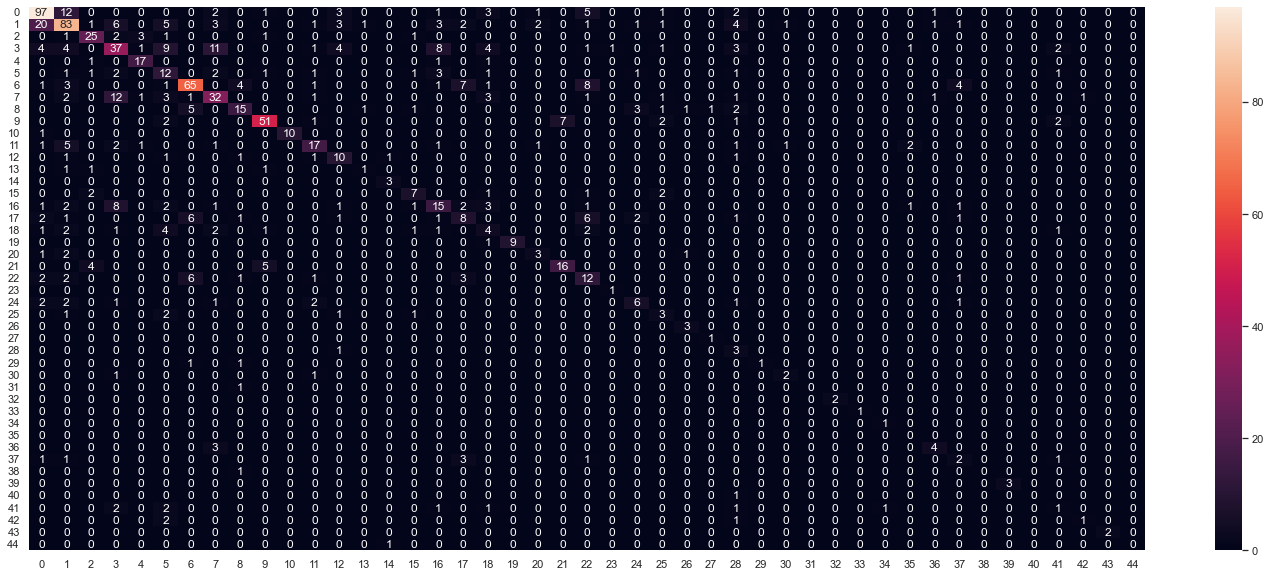

In [259]:
# matriz de confusión
c_matrix = confusion_matrix(y4_test, gs_reg_log4.predict(X4_test))
print(c_matrix)

plt.figure(figsize=(25,10))
sns.heatmap(c_matrix, annot=True);



In [198]:
##### DESPUÉS DE HABER VISTO QUE EL MODELO DEFINITIVO ES EL 4º
## quiero guardar los resultados de predicciones vs valores reales en un dataframe
## PERO, como se puede ver, los tengo aún con valores numéricos y si bien puedo ver si dos 
## valores son iguales o no, lo que yo quiero ver es a qué nombre de vino corresponde cada número
###### lo haré en la siguiente celda aquí abajo
df_preds = pd.DataFrame(predictions, columns = ["PREDICCIONES"])
df_preds["VALOR REAL"] = pd.Series(y4_test)
df_preds.head()

,PREDICCIONES,VALOR REAL
0,1.0,2.0
1,1.0,23.0
2,2.0,1.0
3,8.0,8.0
4,7.0,23.0


In [202]:
vars_100.head(3)  ## este es el dataframe con la leyenda (a cada variedad corresponde un número)

,variety,variety_100
0,Pinot Noir,1
1,Chardonnay,2
2,Red Blend,3


In [229]:
char2idx   ## este es el diccionario con la leyenda de los vinos

## creo la función que me aplica, a cada número, su nombre real
def decodificar_valores(x):
    for pos,val in num_to_string.items():
        if x==val:
            x=pos
            return x
    return x

In [230]:
# aplico la función a las 2 columnas del dataframe de las predicciones

## defino el diccionario con la leyenda de los valores (char2idx  --> lo creé al principio del notebook para transformar la columna "variety" a numérica)
num_to_string = char2idx
## aplico la función
df_preds["VALOR REAL nombre"] = df_preds["VALOR REAL"].apply(decodificar_valores)
df_preds["PREDICCIONES nombre"] = df_preds["PREDICCIONES"].apply(decodificar_valores)

In [272]:
## como resultado final, ya no me interesa tener números, quiero ver el nombre del vino, si el modelo lo ha adivinado o no
df_preds_variety = df_preds[["VALOR REAL nombre", "PREDICCIONES nombre"]]
df_preds_variety.head()

,VALOR REAL nombre,PREDICCIONES nombre
0,Red Blend,Chardonnay
1,Shiraz,Chardonnay
2,Chardonnay,Red Blend
3,Rosé,Rosé
4,Shiraz,Malbec


In [210]:
## guardo este dataframe con las predicciones
df_preds_variety.to_csv("..\\data\\processed\\predicciones_vs_reales.csv", index=False)

In [239]:
predicciones = pd.read_csv("..\\data\\processed\\predicciones_vs_reales.csv")
predicciones.head()

,VALOR REAL nombre,PREDICCIONES nombre
0,Red Blend,Chardonnay
1,Shiraz,Chardonnay
2,Chardonnay,Red Blend
3,Rosé,Rosé
4,Shiraz,Malbec


In [238]:
### quiero ver, de los 1016 registros, cuántos he acertado:
aciertos = predicciones[predicciones["VALOR REAL nombre"] == predicciones["PREDICCIONES nombre"]]
aciertos.head()

,VALOR REAL nombre,PREDICCIONES nombre
3,Rosé,Rosé
7,Rosé,Rosé
8,Syrah,Syrah
10,Cabernet Franc,Cabernet Franc
11,Shiraz,Shiraz


In [237]:
print("De los {} registros de test, el modelo ha acertado {}".format(len(predicciones), len(aciertos)))
### Efectivamente, poco más de la mitad, me cuadra que el score fuera de un 58% aprox

De los 1016 registros de test, el modelo ha acertado 586


## Guardo el modelo


In [64]:
filename = '../models/Modelo_Reg_Log.model'   ### es un archivo tipo pickel que me está guardando mi modelo (se crea cuando ejecuto esta celda)

with open(filename, 'wb') as archivo_salida:
    pickle.dump(best_model_RL4, archivo_salida)

hago una prueba de cargar ese modelo guardado

In [65]:
with open('../models/Modelo_Reg_Log.model', "rb") as archivo_entrada:
    pipeline_importada = pickle.load(archivo_entrada)
    
print(pipeline_importada)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('reglog4',
                 LogisticRegression(C=21.544346900318832, max_iter=1000))])


# CONSIDERACIONES FINALES Y DECLARACIÓN DEL MODELO ELEGIDO
Después de hacer la última prueba, usando las review (en el notebook 04), veo que me da hasta peores resultados que los que he obtenido hasta aquí, no llegando ni a un 50% de aciertos.

Finalmente mi modelo definitivo es él que he guardado aquí, el de Logistic Regression, con un porcentaje de aciertos de casi un 58%.

Al principio estaba un poco mosqueada con el resultado, pero reflexionando mejor puedo sascar unos puntos positivos a mi proyectos:
- he partido de unos scores bajísimos cuando era un problema de regresion (un 0.44 de score y el RMSE mas bajo era de 21, o sea un error de 21$ sobre los precios, para nada bueno) y los he ido mejorando conforme iba cambiando el enfoque de mi proyecto, pasando finalmente a un problema de clasificación, intentando predecir el tipo de vino (la variedad) en vez que su precio.
- También he ido mejorando poco a poco los scores con el problema de clasificación, pasando de un 43% aprox (con alguna caída hasta el 12% y 19% de aciertos) hasta llegar finalmente a un casi 58% de aciertos (57,67% para ser exactos).
- Está claro que hasta el mejor sommelier, frente a una cata a ciega, no siempre (o practicamente nunca) llega a un porcentaje de aciertos del 100%, así que me conformaré con mi resultado y puede que, más adelante, lo varia revisando con más técnicas que vaya aprendiendo por el camino y, quizas, pueda obtener unos resultados mejores.